# Prevendo *Customer Churn* em Operadoras de Telecom

## Importando as bibliotecas necessárias

In [646]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #importando o pacote pandas
import numpy as np #pacote numérico numpy
import time
import pickle
from itertools import product
from itertools import combinations

#visualização de dados
from matplotlib import pyplot as plt
import seaborn as sns #pacote seaborn para construção de gráficos

#SMOTE
from imblearn.over_sampling import SVMSMOTE #importando a função SMOTE

#SKLEARN
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler # importando função para a Padronização dos dados
from sklearn.metrics import confusion_matrix #matriz de confusão

#Importando pacotes de Tuning
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

#Importando os algoritmos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

## Criando uma função para explorar os dados

In [579]:
# Criando uma função que retorna um dataframe de descrição de dados (tal qual a função describe do pacote explore do R)
def explore_describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [len(df[coluna]) - df[coluna].count() for coluna in df.columns]
    df_out['na_pct'] = df_out.na/len(df_out.na)*100
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [min(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [max(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [df[coluna].skew() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [df[coluna].kurt() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['media_desvio'] = [round(df[coluna].mean()/df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                                'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    return(df_out)


## Importando o dataset de treino

In [580]:
treino = pd.read_csv("projeto4_telecom_treino.csv",header=0)
treino

Unnamed: 0 state  account_length      area_code international_plan  \
0              1    KS             128  area_code_415                 no   
1              2    OH             107  area_code_415                 no   
2              3    NJ             137  area_code_415                 no   
3              4    OH              84  area_code_408                yes   
4              5    OK              75  area_code_415                yes   
...          ...   ...             ...            ...                ...   
3328        3329    AZ             192  area_code_415                 no   
3329        3330    WV              68  area_code_415                 no   
3330        3331    RI              28  area_code_510                 no   
3331        3332    CT             184  area_code_510                yes   
3332        3333    TN              74  area_code_415                 no   

     voice_mail_plan  number_vmail_messages  total_day_minutes  \
0                yes                     25              265.1   
1                yes                     26              161.6   
2                 no                      0              243.4   
3                 no                      0              299.4   
4                 no                      0              166.7   
...              ...                    ...                ...   
3328             yes                     36              156.2   
3329              no                      0              231.1   
3330              no                      0              180.8   
3331              no                      0              213.8   
3332             yes                     25              234.4   

      total_day_calls  total_day_charge  ...  total_eve_calls  \
0                 110             45.07  ...               99   
1                 123             27.47  ...              103   
2                 114             41.38  ...              110   
3                  71             50.90  ...               88   
4                 113             28.34  ...              122   
...               ...               ...  ...              ...   
3328               77             26.55  ...              126   
3329               57             39.29  ...               55   
3330              109             30.74  ...               58   
3331              105             36.35  ...               84   
3332              113             39.85  ...               82   

      total_eve_charge  total_night_minutes  total_night_calls  \
0                16.78                244.7                 91   
1                16.62                254.4                103   
2                10.30                162.6                104   
3                 5.26                196.9                 89   
4                12.61                186.9                121   
...                ...                  ...                ...   
3328             18.32                279.1                 83   
3329             13.04                191.3                123   
3330             24.55                191.9                 91   
3331             13.57                139.2                137   
3332             22.60                241.4                 77   

      total_night_charge  total_intl_minutes  total_intl_calls  \
0                  11.01                10.0                 3   
1                  11.45                13.7                 3   
2                   7.32                12.2                 5   
3                   8.86                 6.6                 7   
4                   8.41                10.1                 3   
...                  ...                 ...               ...   
3328               12.56                 9.9                 6   
3329                8.61                 9.6                 4   
3330                8.64                14.1                 6   
3331                6.26                 5.0                10   


In [581]:
#Primeira coluna contém o indice de alguma exportação do Python. Dessa forma, vamos remover essa coluna
treino = treino.loc[:,'state':]
treino

state  account_length      area_code international_plan voice_mail_plan  \
0       KS             128  area_code_415                 no             yes   
1       OH             107  area_code_415                 no             yes   
2       NJ             137  area_code_415                 no              no   
3       OH              84  area_code_408                yes              no   
4       OK              75  area_code_415                yes              no   
...    ...             ...            ...                ...             ...   
3328    AZ             192  area_code_415                 no             yes   
3329    WV              68  area_code_415                 no              no   
3330    RI              28  area_code_510                 no              no   
3331    CT             184  area_code_510                yes              no   
3332    TN              74  area_code_415                 no             yes   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3328                     36              156.2               77   
3329                      0              231.1               57   
3330                      0              180.8              109   
3331                      0              213.8              105   
3332                     25              234.4              113   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                45.07              197.4               99             16.78   
1                27.47              195.5              103             16.62   
2                41.38              121.2              110             10.30   
3                50.90               61.9               88              5.26   
4                28.34              148.3              122             12.61   
...                ...                ...              ...               ...   
3328             26.55              215.5              126             18.32   
3329             39.29              153.4               55             13.04   
3330             30.74              288.8               58             24.55   
3331             36.35              159.6               84             13.57   
3332             39.85              265.9               82             22.60   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   244.7                 91               11.01   
1                   254.4                103               11.45   
2                   162.6                104                7.32   
3                   196.9                 89                8.86   
4                   186.9                121                8.41   
...                   ...                ...                 ...   
3328                279.1                 83               12.56   
3329                191.3                123                8.61   
3330                191.9                 91                8.64   
3331                139.2                137                6.26   
3332                241.4                 77               10.86   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   10.0                 3               2.70   
1                   13.7                 3               3.70   
2                   12.2                 5               3.29   
3                    6.6                 7               1.78   
4                   10.1                 3               2.73   
...                  ...               ...                ...   
3328  

In [582]:
#Vamos separar um conjunto de validação, para verificar como o modelo irá se comportar depois de todas as alterações (5% dos dados)
linhas_amostra = np.random.randint(len(treino),size = int(round(len(treino)*0.05,0)))
validacao = treino.iloc[linhas_amostra,:]
treino = treino.drop(index=linhas_amostra)

## Análise exploratória dos dados

Algumas anotações a respeito da descrição dos dados abaixo:
- As variáveis *number_customer_service_calls* e *number_vmail_messages* parecem ser as únicas variáveis numéricas que não seguem uma distribuição normal (<font color=blue> Verificar comportamento em pairplot das variáveis numéricas </font>
- Pelos dados de média, mediana, skewness e kurtosis, podemos verificar que as outras variáveis seguem uma distribuição normal, portanto, não haverá necessidade de <font color = blue> padronização, exceto *number_customer_service_calls* e *number_vmail_messages* </font>

In [583]:
#Realizando uma exploração dos dados inicial
explore_describe(treino)

variable     type  na  na_pct  unique   min  quat25  \
0                           state   object   0     0.0      51     -       -   
1                  account_length    int64   0     0.0     212     1      74   
2                       area_code   object   0     0.0       3     -       -   
3              international_plan   object   0     0.0       2     -       -   
4                 voice_mail_plan   object   0     0.0       2     -       -   
5           number_vmail_messages    int64   0     0.0      45     0       0   
6               total_day_minutes  float64   0     0.0    1626     0   143.5   
7                 total_day_calls    int64   0     0.0     119     0      87   
8                total_day_charge  float64   0     0.0    1626     0    24.4   
9               total_eve_minutes  float64   0     0.0    1575     0  166.15   
10                total_eve_calls    int64   0     0.0     123     0      87   
11               total_eve_charge  float64   0     0.0    1412     0   14.12   
12            total_night_minutes  float64   0     0.0    1550  43.7  167.08   
13              total_night_calls    int64   0     0.0     119    33      87   
14             total_night_charge  float64   0     0.0     920  1.97    7.52   
15             total_intl_minutes  float64   0     0.0     161     0     8.5   
16               total_intl_calls    int64   0     0.0      21     0       3   
17              total_intl_charge  float64   0     0.0     161     0     2.3   
18  number_customer_service_calls    int64   0     0.0      10     0       1   
19                          churn   object   0     0.0       2     -       -   

    median    mean  quat75    max    std   skewness   kurtosis media_desvio  
0        -       -       -      -      -          -          -            -  
1      100  101.12     127    243  39.83   0.108917 -0.0852961         2.54  
2        -       -       -      -      -          -          -            -  
3        -       -       -      -      -          -          -            -  
4        -       -       -      -      -          -          -            -  
5        0    8.14      20     51  13.72    1.25712  -0.071026         0.59  
6   179.25  179.66   216.6  350.8  54.43 -0.0356622 -0.0404305          3.3  
7      101  100.41     114    165  20.06  -0.104897   0.270263         5.01  
8    30.47   30.54   36.82  59.64   9.25 -0.0356655 -0.0402903          3.3  
9    201.4  200.96   235.3  363.7  50.75 -0.0163336  0.0238789         3.96  
10     100   99.99  113.25    170  19.97  -0.065121   0.218634         5.01  
11   17.12   17.08      20  30.91   4.31 -0.0163253  0.0237771         3.96  
12   201.1  200.82  235.12    395  50.42  0.0166104  0.0480416         3.98  
13     100  100.07     113    175   19.6  0.0434135 -0.0708108         5.11  
14    9.05    9.04   10.58  17.77   2.27  0.0165934  0.0477918         3.98  
15    10.3   10.22    12.1     20   2.81  -0.242374   0.622176         3.64  
16       4    4.48       6     20   2.46    1.30028    2.97862         1.82  
17    2.78    2.76    3.27    5.4   0.76  -0.242526   0.622311         3.65  
18       1    1.57       2      9   1.31    1.09102    1.75425         1.19  
19       -       -       -      -      -          -          -            -

Há um desbalanceamento de variáveis, por isso, há necessidade de aplica <font color = blue> SMOTE </font>

In [584]:
#Verificando a proporção das classes
contagem = treino.groupby('churn')[['churn']].count()
contagem.assign(percent = 100*contagem.churn/sum(contagem.churn))

churn    percent
churn                  
no      2710  85.435057
yes      462  14.564943

Algumas anotações a respeito da descrição dos dados abaixo:
- Realmente as variáveis descritas anteriormente parecem seguir uma distribuição normal, exceto *number_vmail_messages* e *number_customer_service_calls*

In [585]:
#Pela quantidade de variaveis, vamos apenas realizar um mapeamento das variáveis, para facilitar a identificação no pairplot
mapeamento = {}
for i in range(0,len(treino.columns)-1):
    mapeamento[treino.columns[i]] = i
mapeamento

{'state': 0,
 'account_length': 1,
 'area_code': 2,
 'international_plan': 3,
 'voice_mail_plan': 4,
 'number_vmail_messages': 5,
 'total_day_minutes': 6,
 'total_day_calls': 7,
 'total_day_charge': 8,
 'total_eve_minutes': 9,
 'total_eve_calls': 10,
 'total_eve_charge': 11,
 'total_night_minutes': 12,
 'total_night_calls': 13,
 'total_night_charge': 14,
 'total_intl_minutes': 15,
 'total_intl_calls': 16,
 'total_intl_charge': 17,
 'number_customer_service_calls': 18}

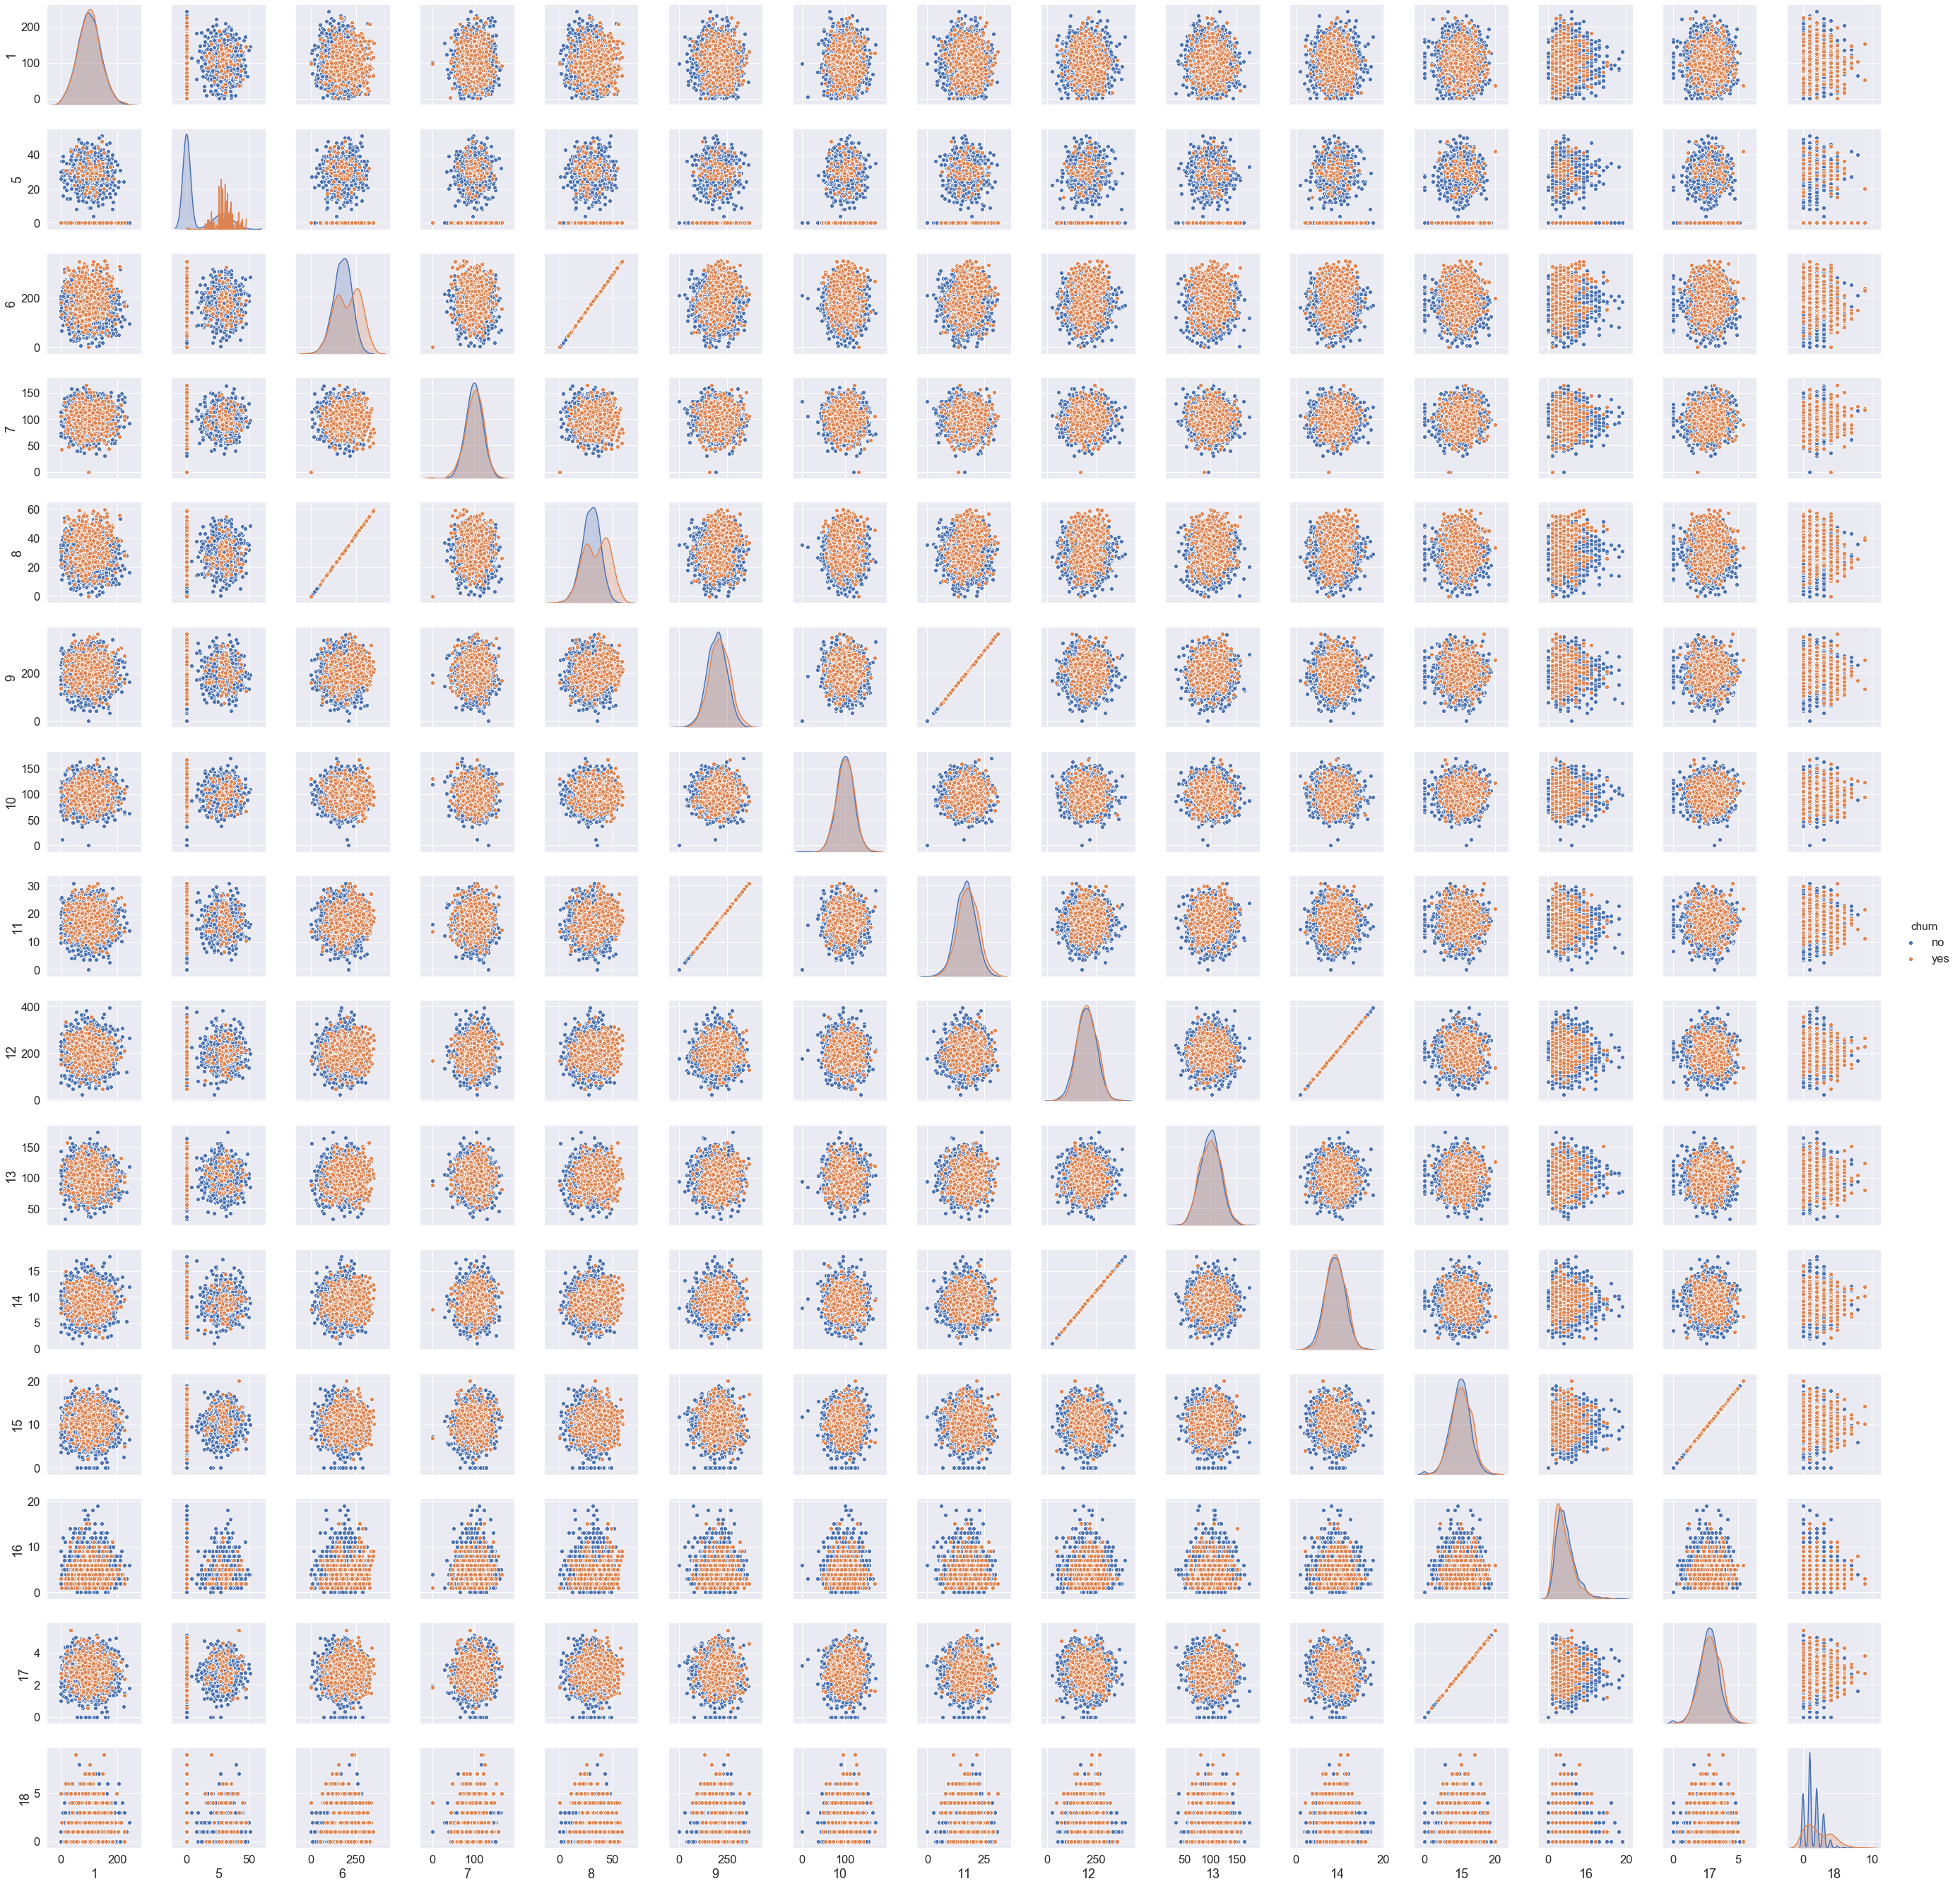

In [178]:
#Usando a função pairs do pacote seaborn para dar uma olhada na distribuição das variáveis numéricas
sns.set(font_scale=1.5)
sns.pairplot(treino.rename(columns = mapeamento),hue = 'churn')

É notavel, tanto pelo gráfico de dispersão, tanto pelo mapa de correlação (agora ainda mais evidente) que existe uma dependencia linear entre algumas variáveis, sempre respeitando:

__**_charge*__ e __**_minutes*__

Por isso, <font color = blue> podemos remover um dos pares </font>, para faciliar a modelagem e não permitir dependência linear entre elas

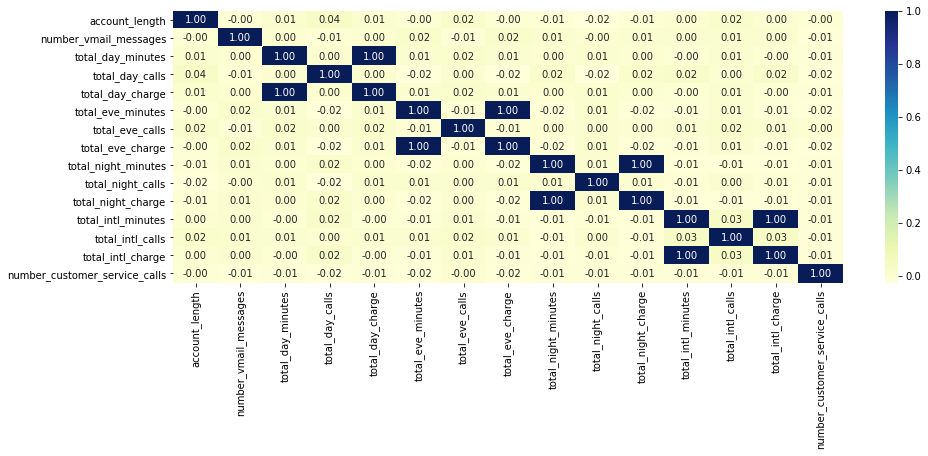

In [586]:
#Analisando a correlação entre as variáveis
plt.subplots(figsize=(15,5))
sns.heatmap(treino.corr(), annot=True, fmt=".2f",cmap="YlGnBu")

Vamos verificar se existe algum comportamento relevante em um barplot, quando olhamos cada estado

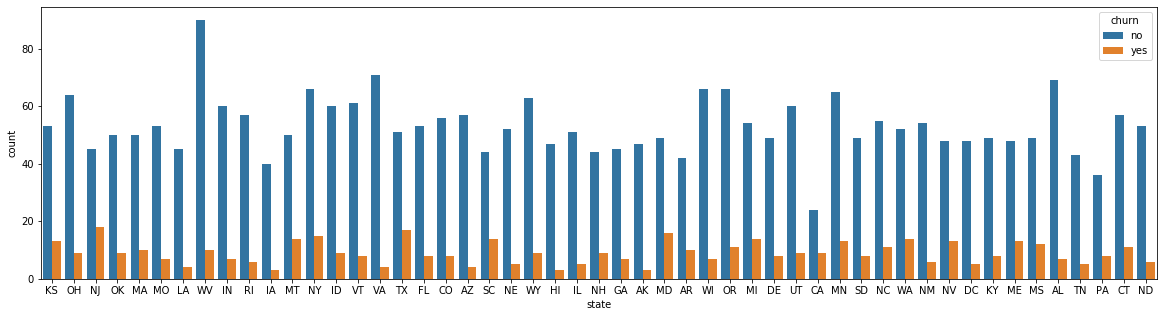

In [587]:
figsize=(20,5)
plt.subplots(figsize=figsize)
sns.countplot(x = 'state',data=treino,hue = 'churn')

Vamos verificar se, a partir de boxplot, conseguimos verificar alguma informação por estado

In [588]:
#Definindo uma função bloxplot, para mostrar a situação das variáveis por estado
def boxplot_state(xy,dataset,hue,figsize):
    plt.subplots(figsize=figsize)
    sns.boxenplot(x=xy[0],y=xy[1],data=dataset,hue = hue)

In [589]:
#Encontrando quem sao as variáveis categóricas e numéricas
categoricas = explore_describe(treino)['variable'][explore_describe(treino)['type'].\
                                         map(lambda x: True if ('object' in str(x)) else False)]
categoricas = categoricas[categoricas != 'churn'].to_list()

numericas = explore_describe(treino)['variable'][explore_describe(treino)['type'].\
                                         map(lambda x: True if (('int' in str(x)) or ('float' in str(x))) else False)].to_list()


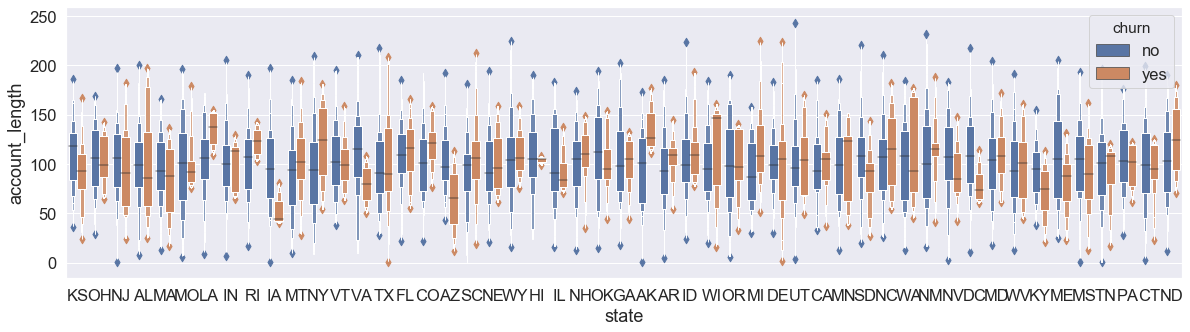

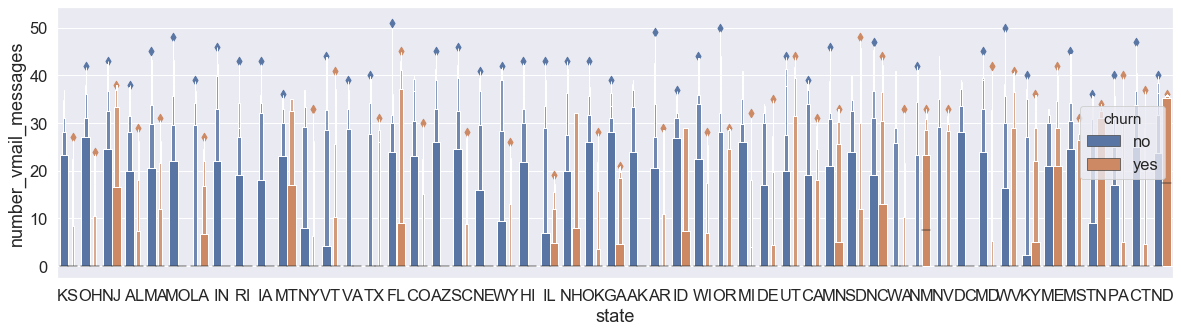

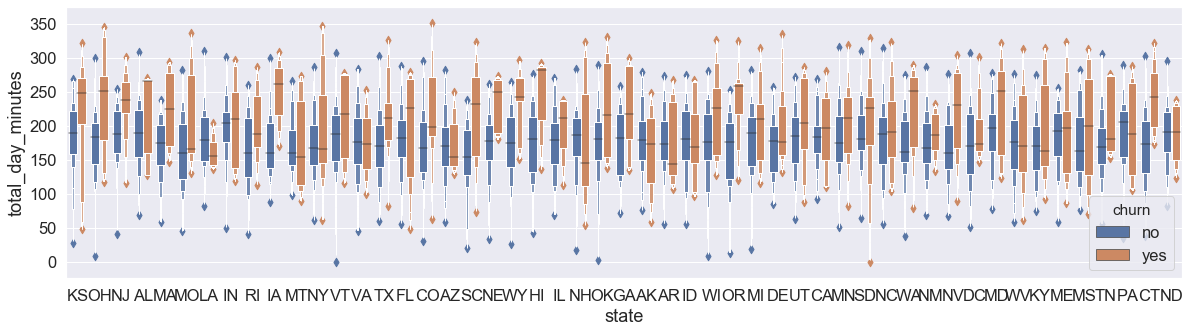

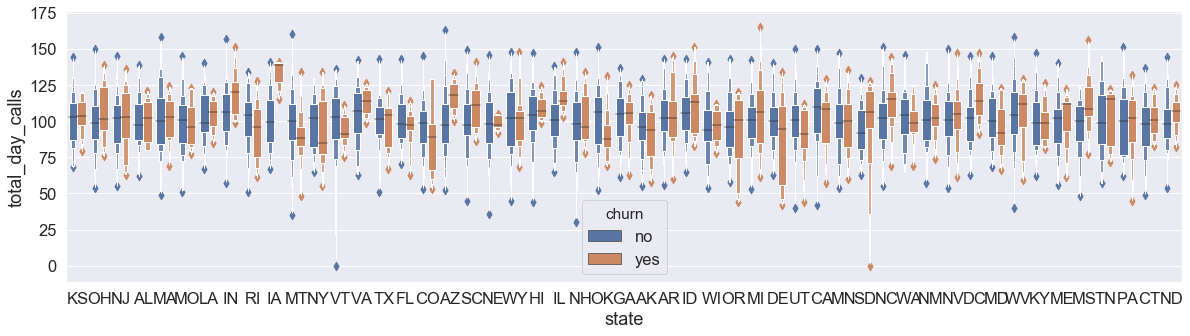

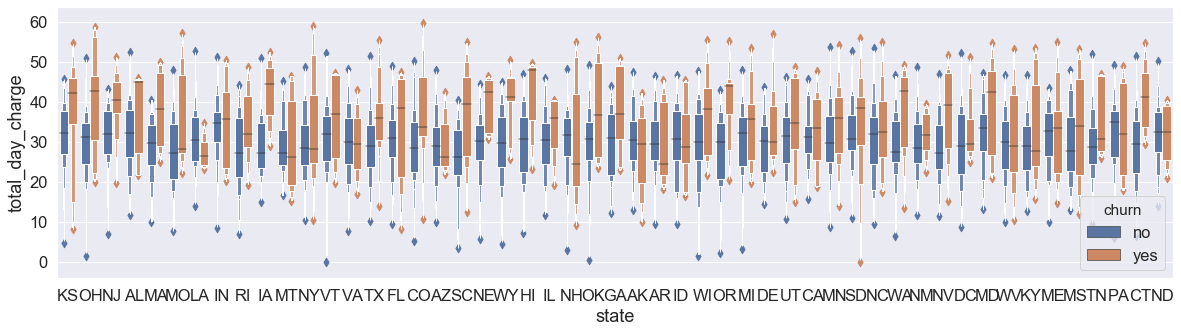

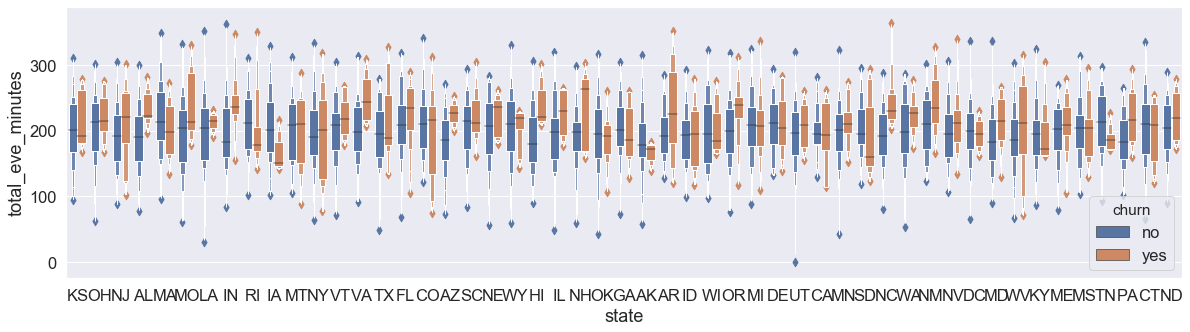

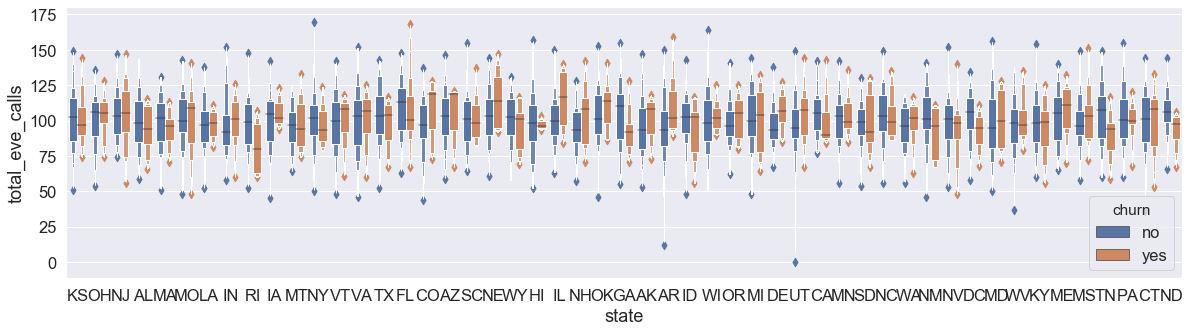

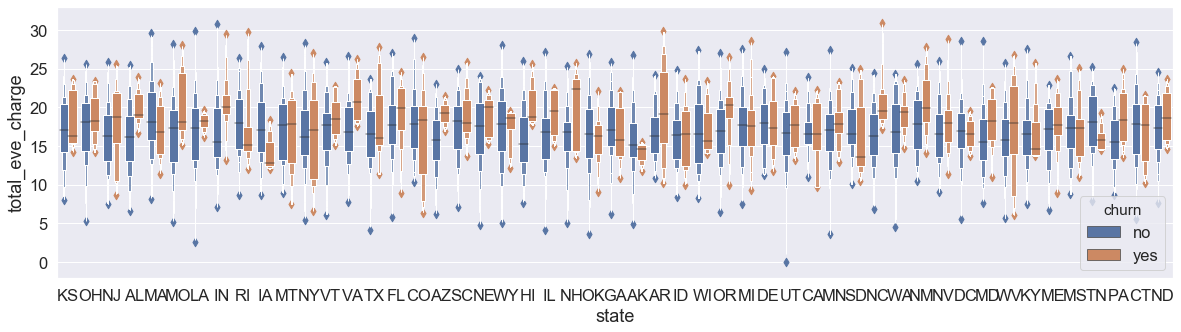

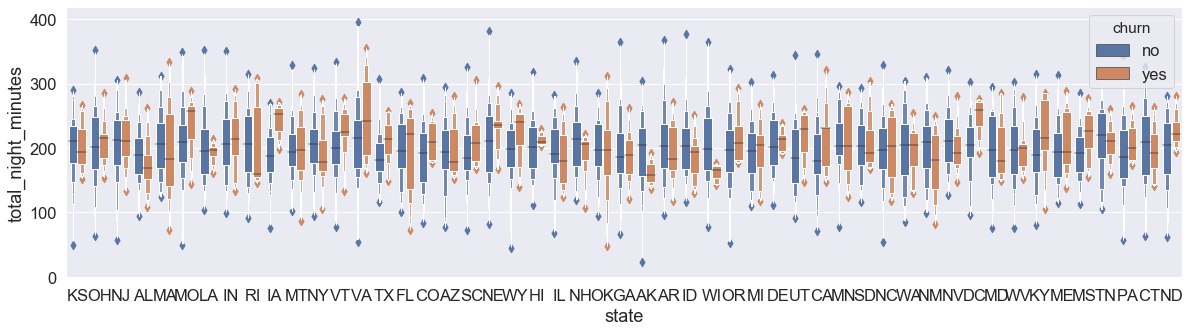

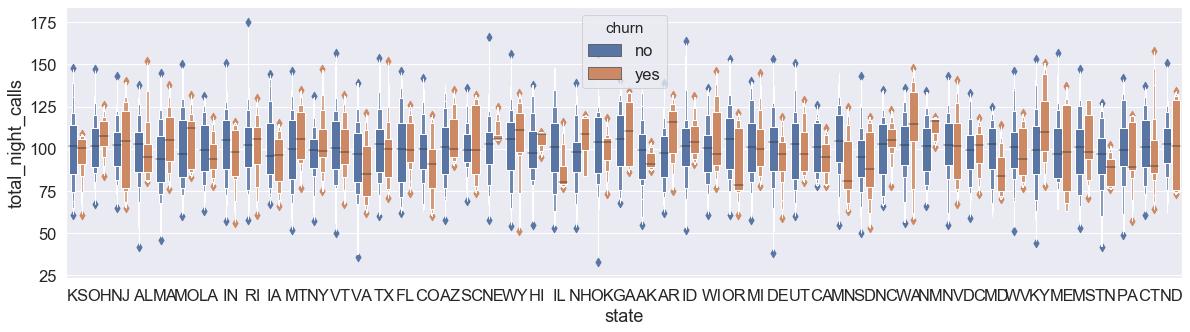

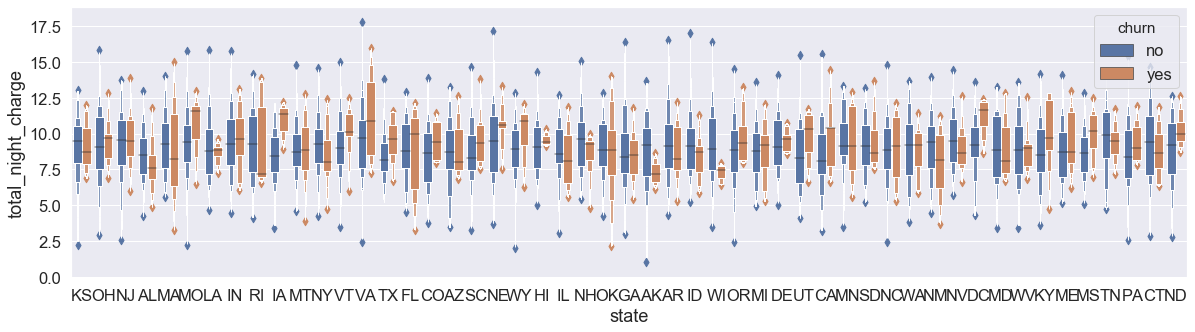

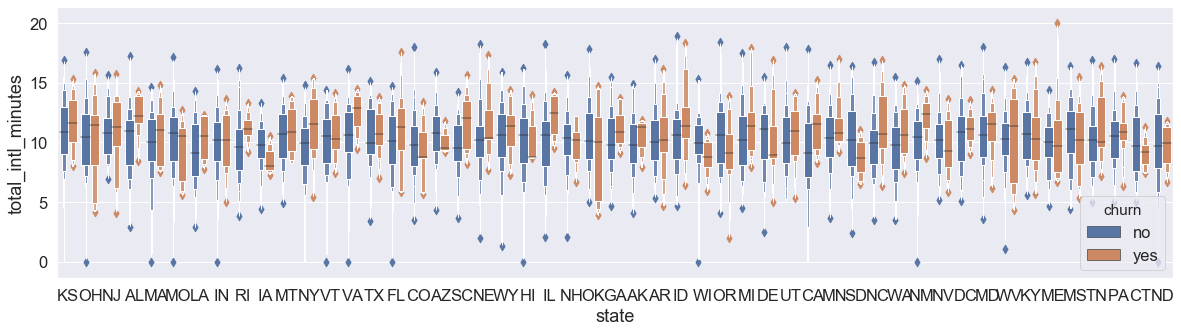

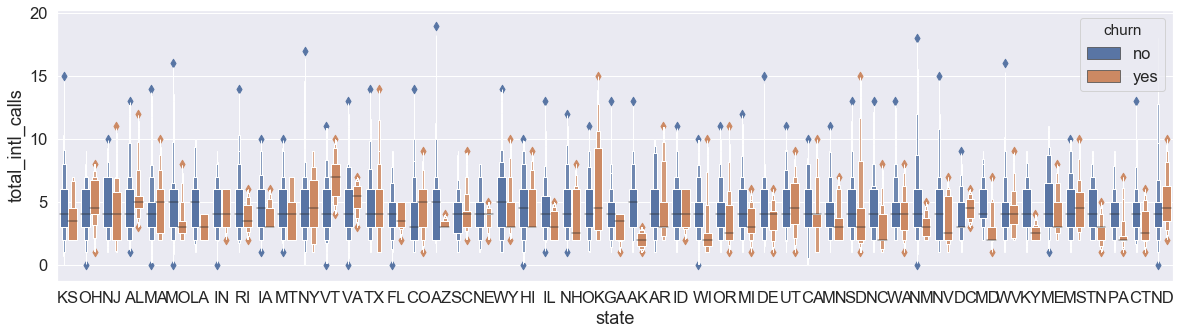

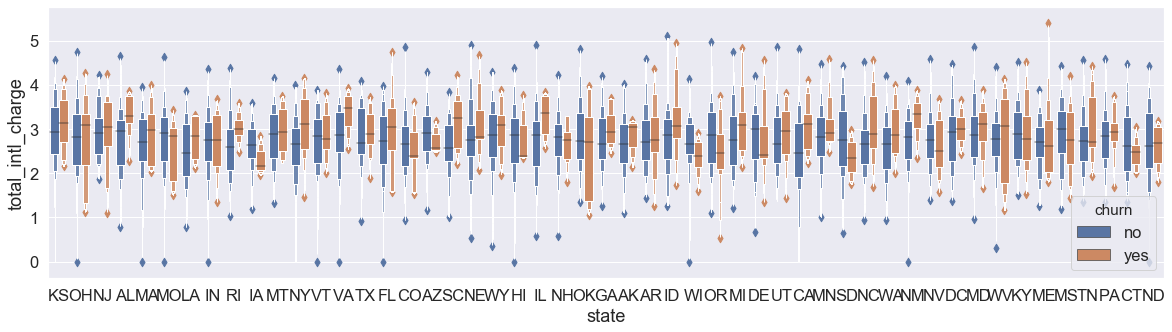

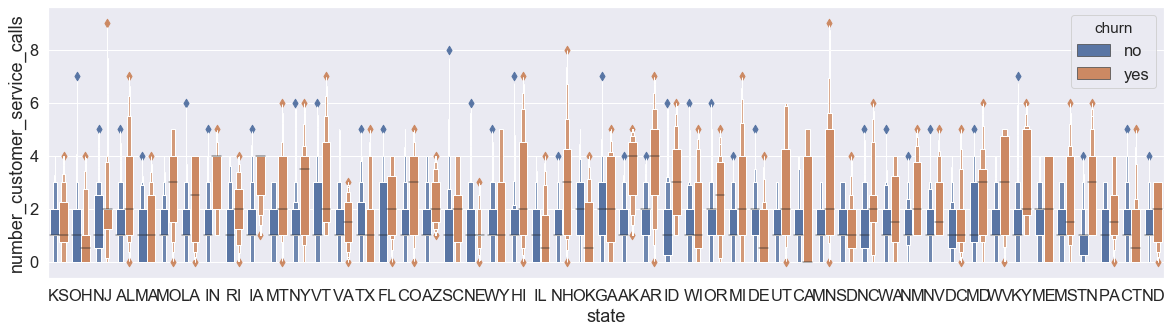

In [183]:
for xy in list(product(['state'],numericas)):
    boxplot_state(xy,treino,'churn',(20,5))

In [590]:
#Verificando as deis variáveis
categoricas_sem_state = list(filter(lambda x: True if x != 'state' else False,categoricas))

- Pelos box plots abaixo, nota-se claramente, que para a variável *number_vmail_message*, quem apresentou *churn* positivo teve, em sua grande maioria, nenhum *vmail*. <font color=blue> Forte variável para a modelagem </font>;
- A variância existente para *number_customer_service_calls* é bem maior quando o *churn* é positivo, do que quando o churn é negativo;

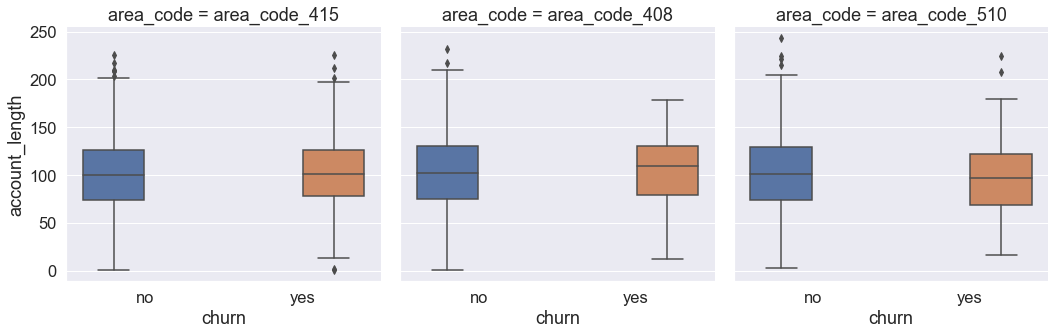

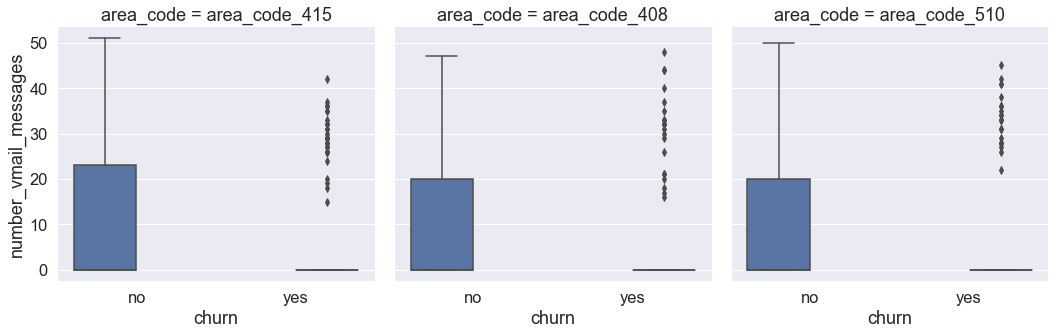

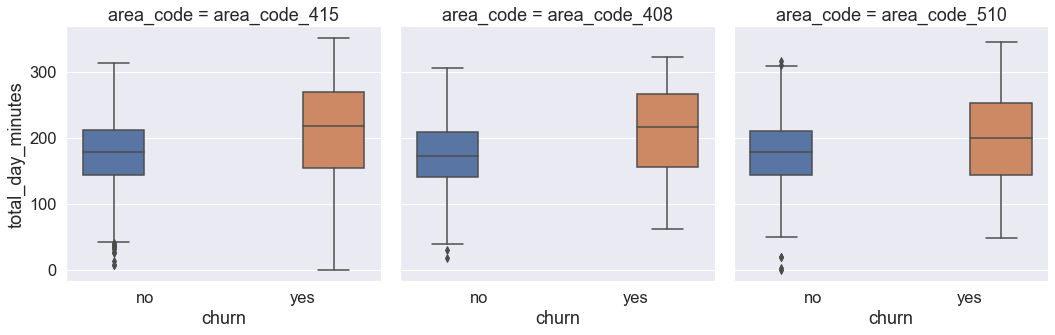

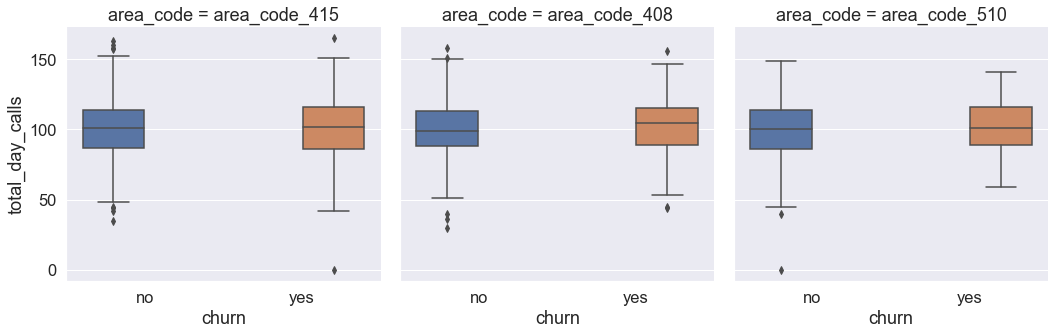

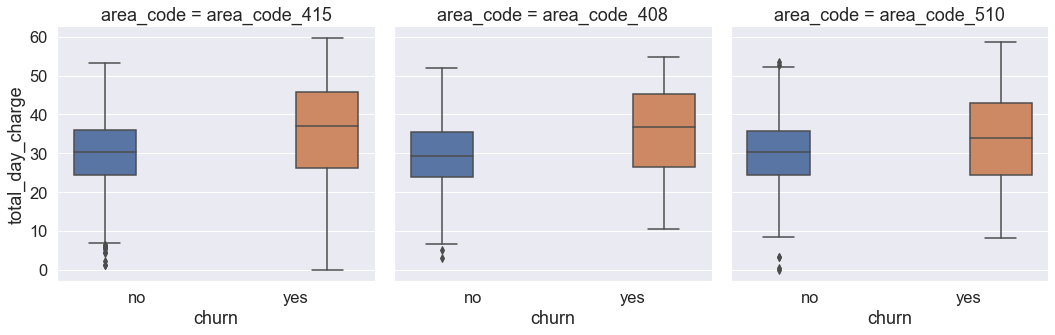

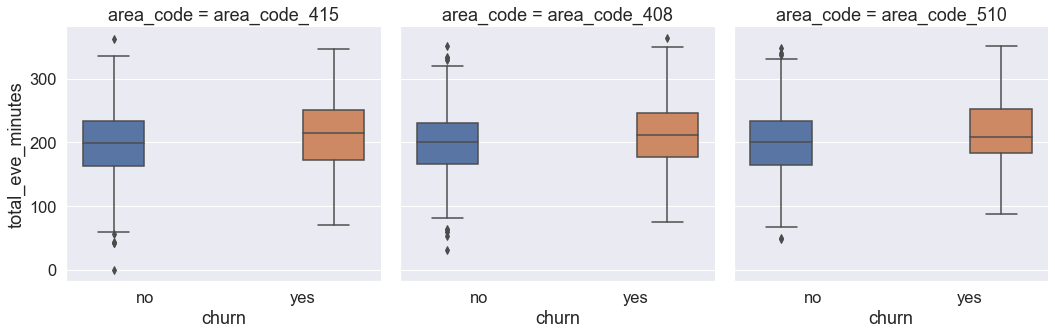

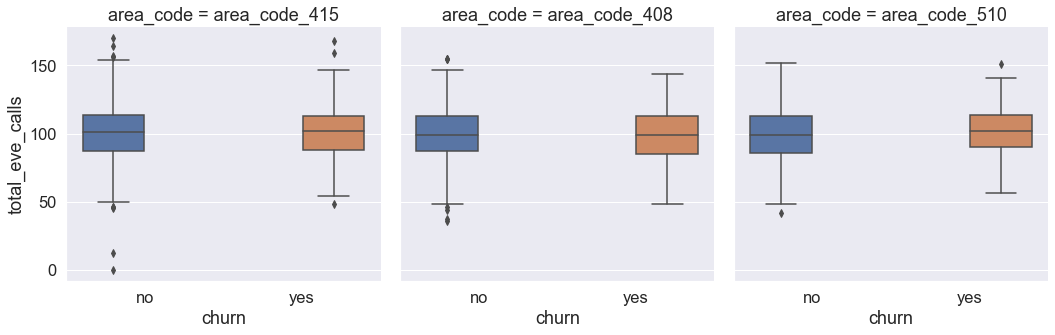

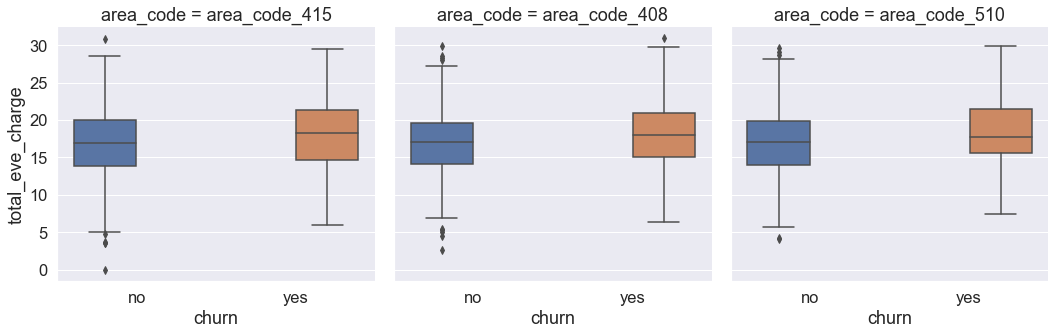

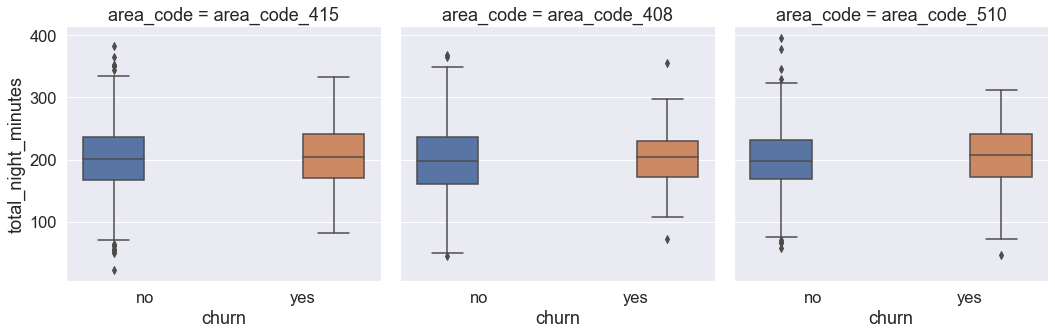

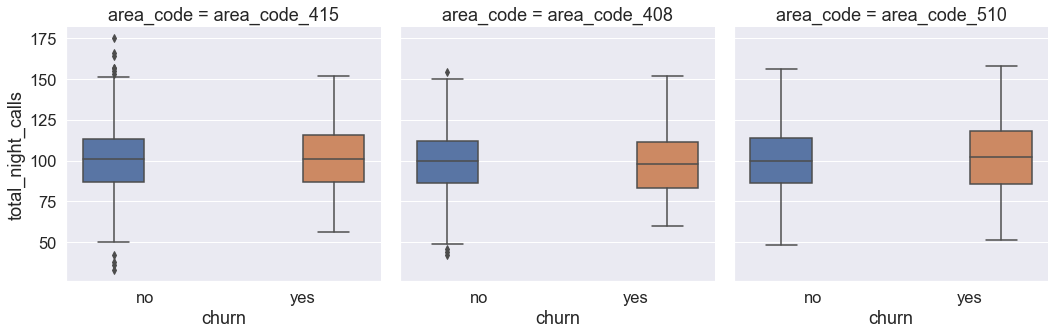

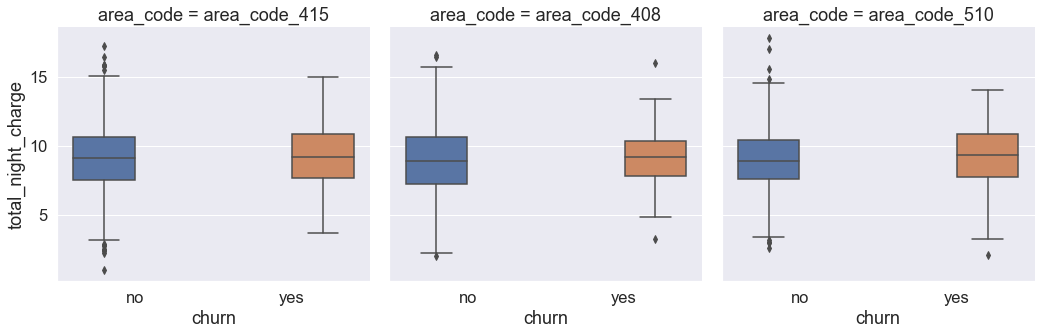

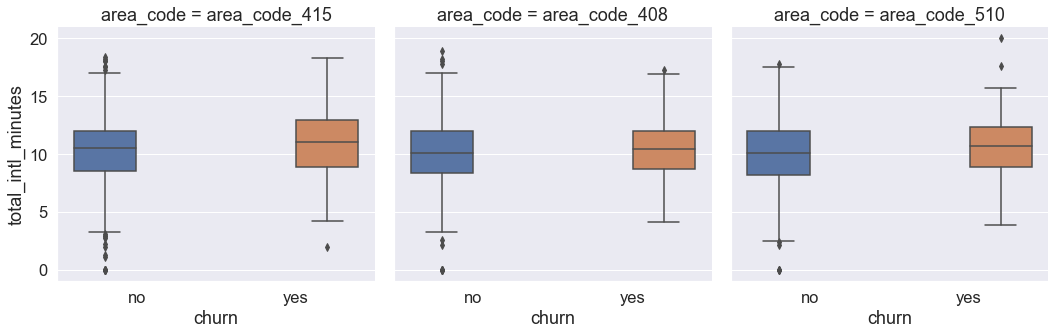

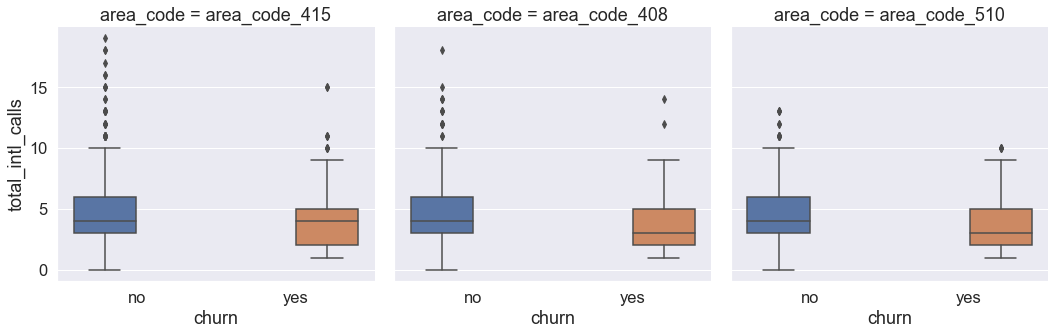

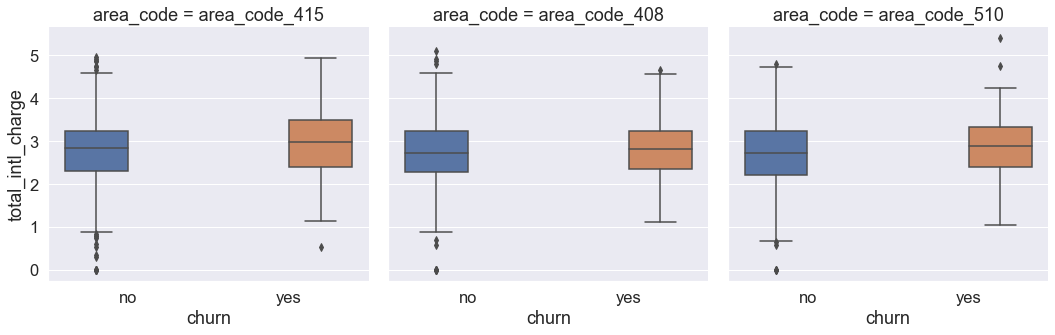

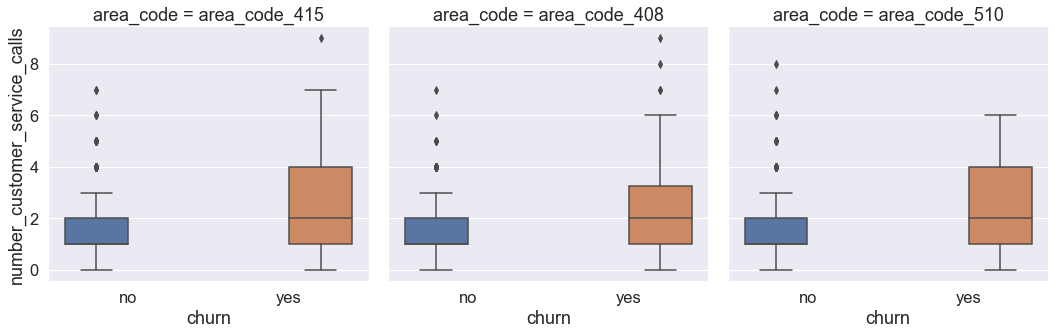

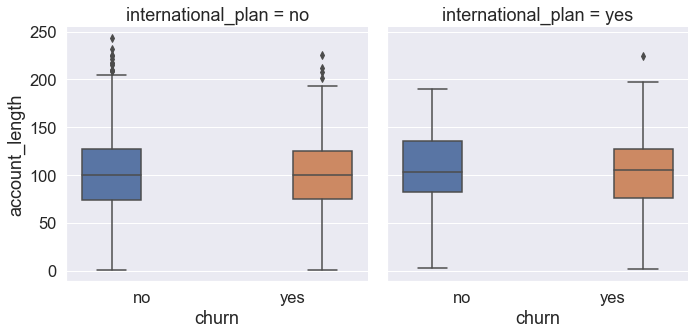

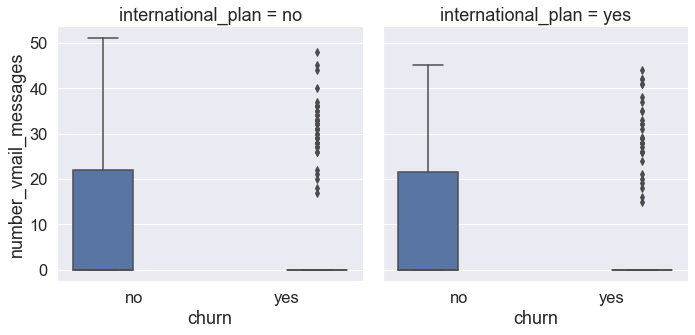

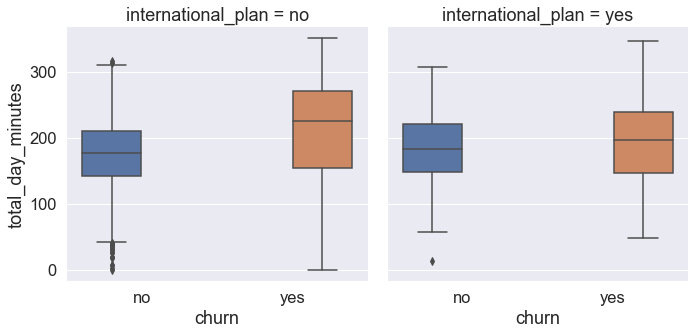

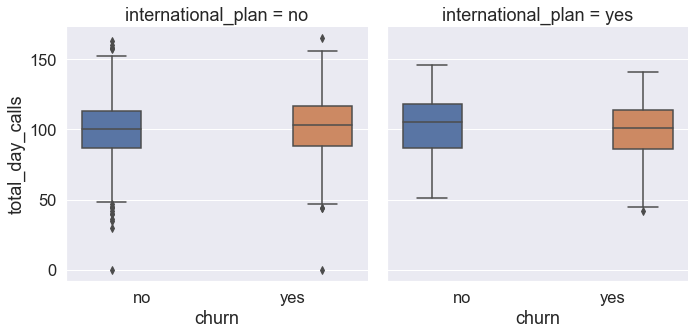

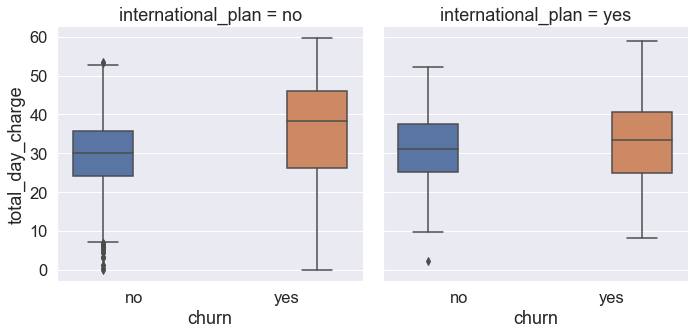

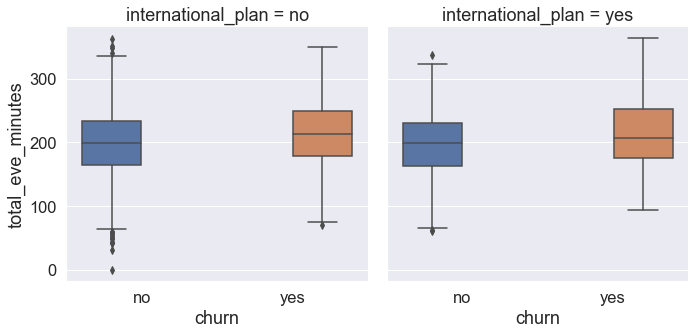

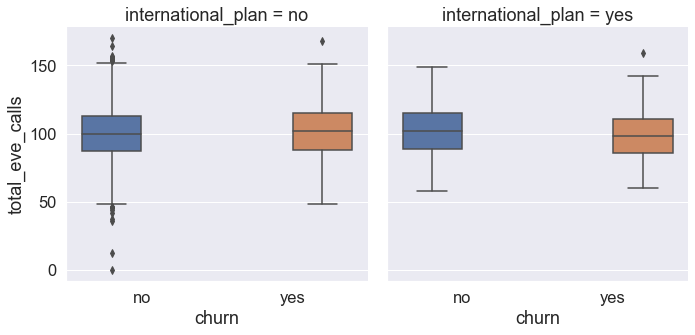

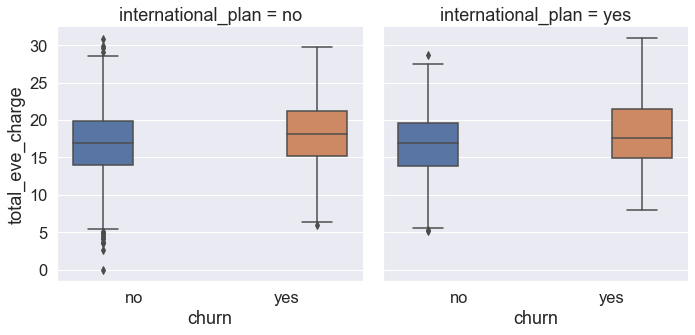

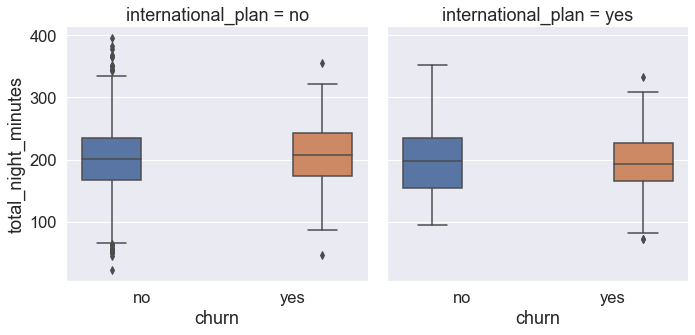

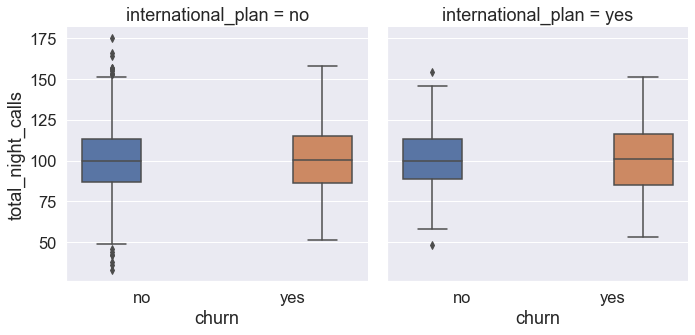

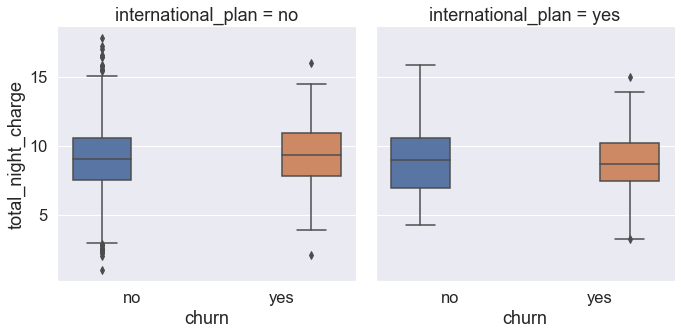

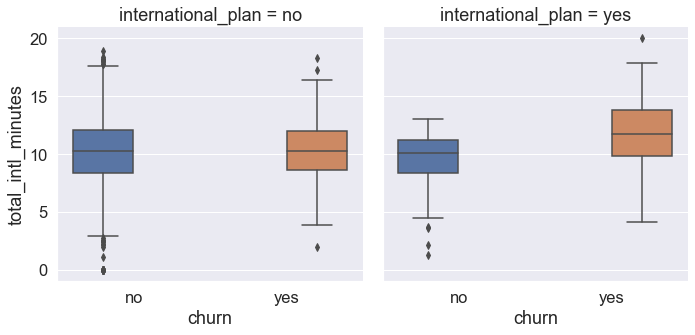

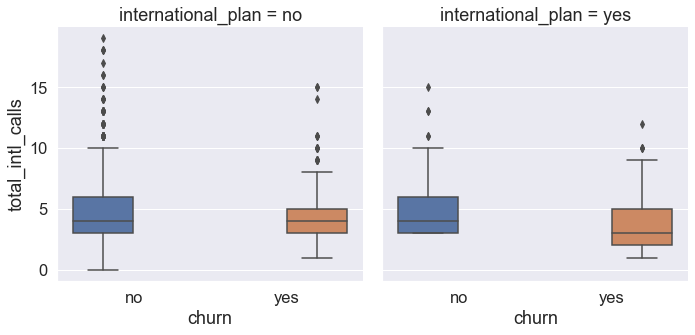

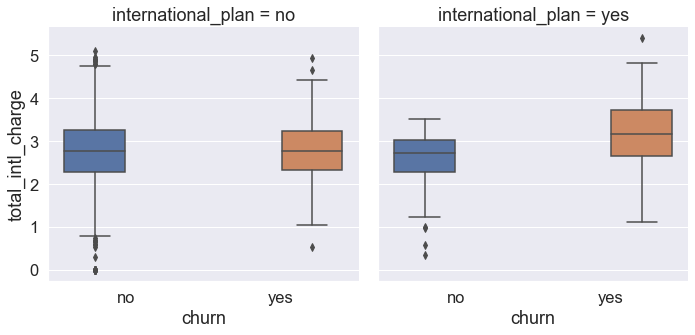

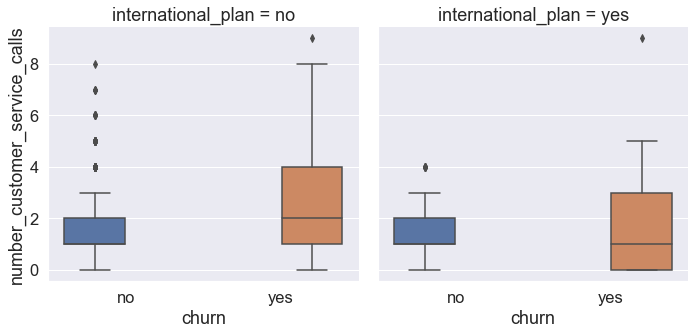

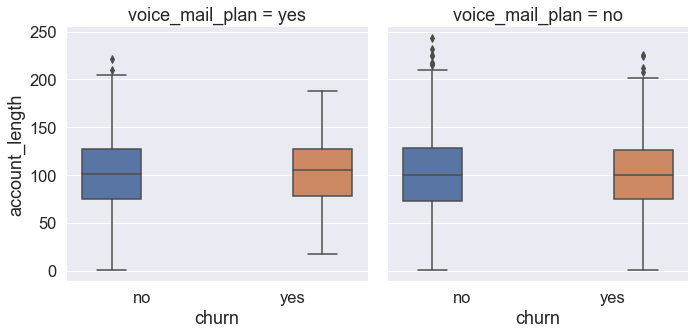

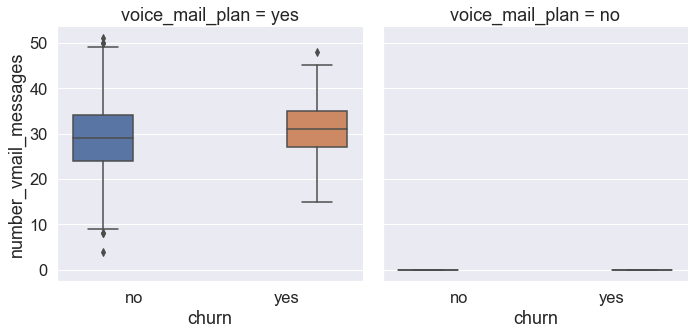

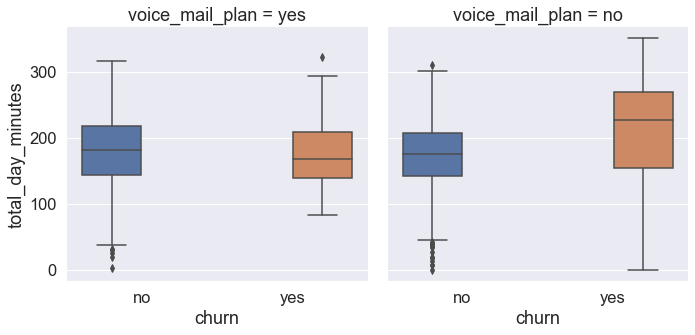

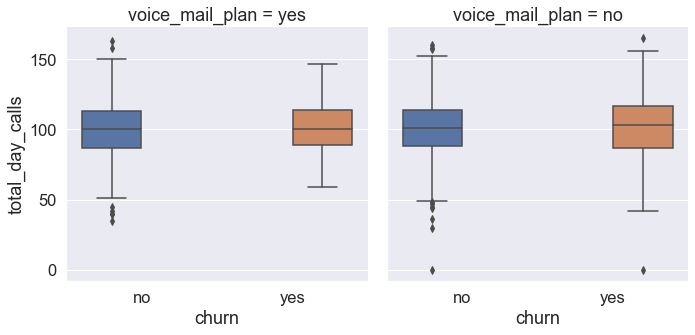

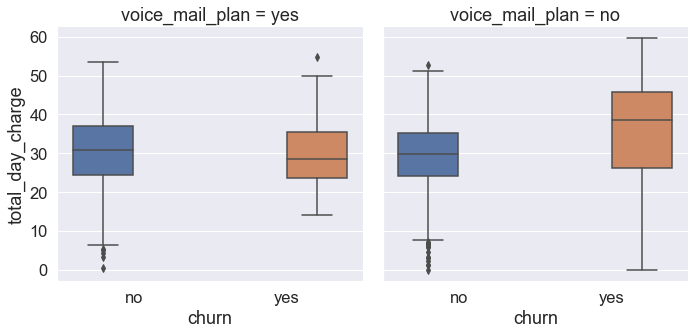

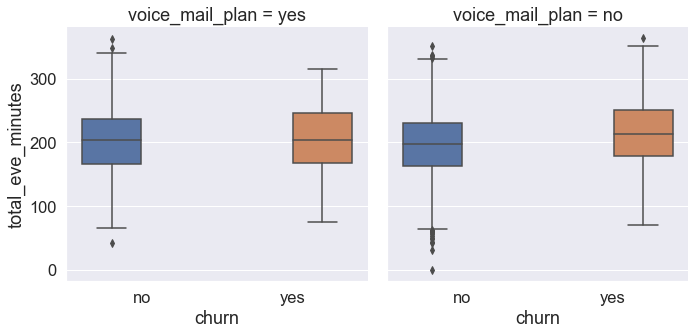

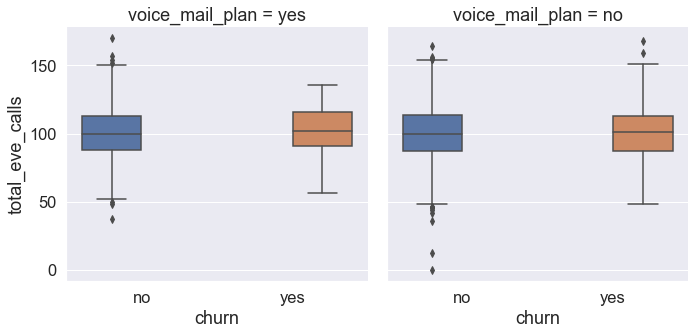

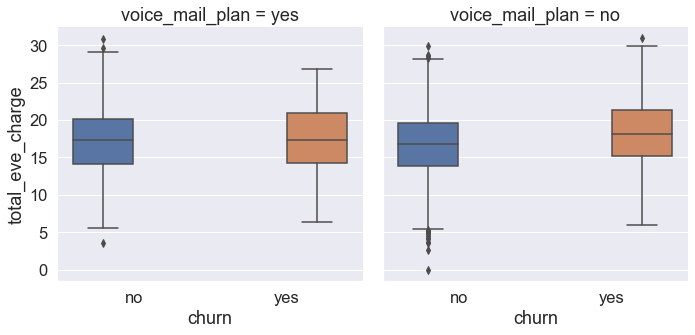

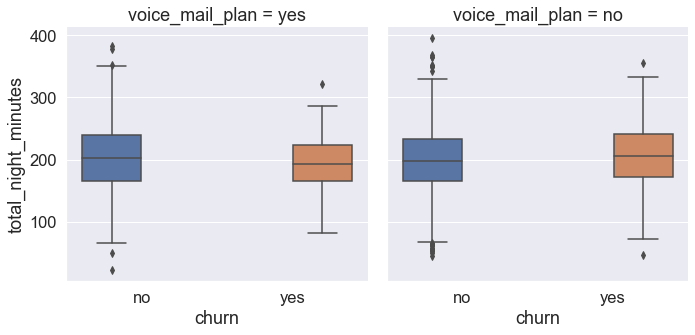

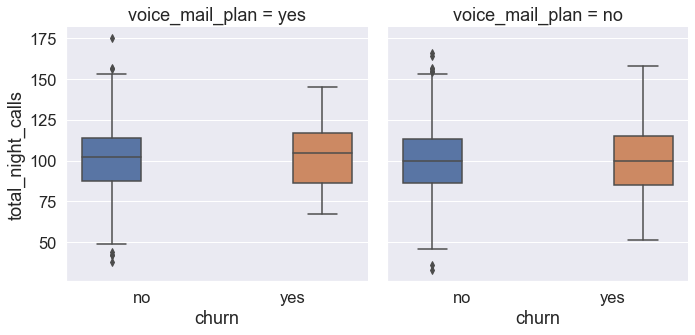

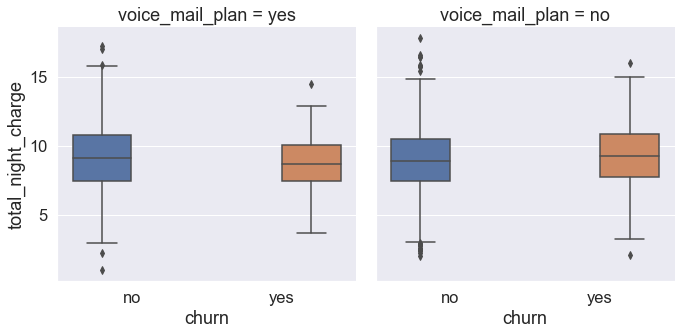

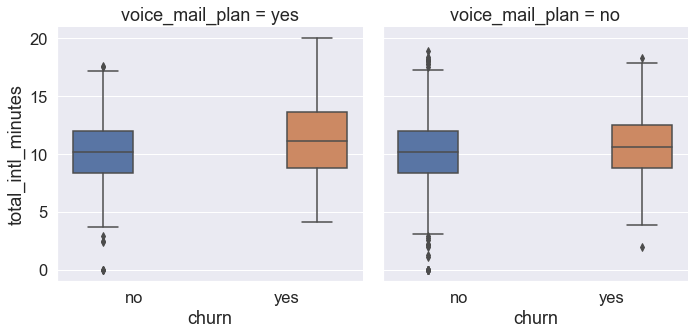

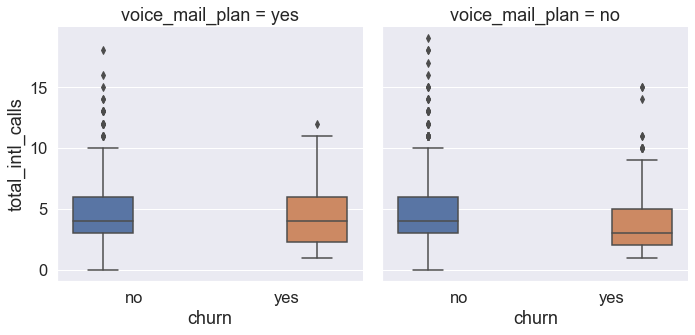

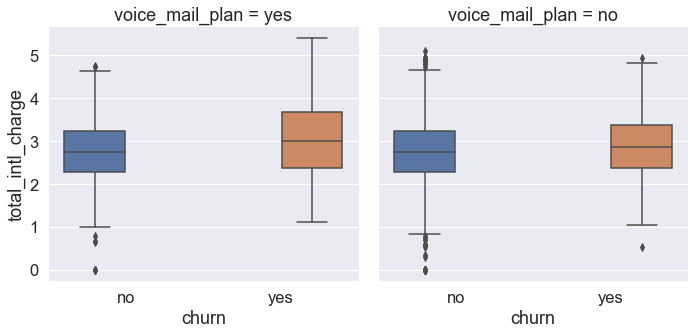

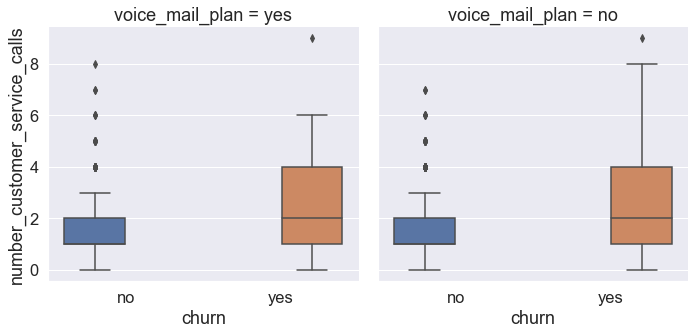

In [185]:
for xy in product(categoricas_sem_state,numericas):
    sns.catplot(col = xy[0], x = 'churn',y = xy[1], hue = "churn", data=treino, kind="box")

Para cada uma das variáveis categóricas, vamos ver como está a relação do *churn*
- Nota-se que, para o caso de não haver pacote internacional, o *churn* negativo é bem maior que o *churn* positivo. Dessa forma, pode ser uma hipótese que não ter o pacote internacional, 

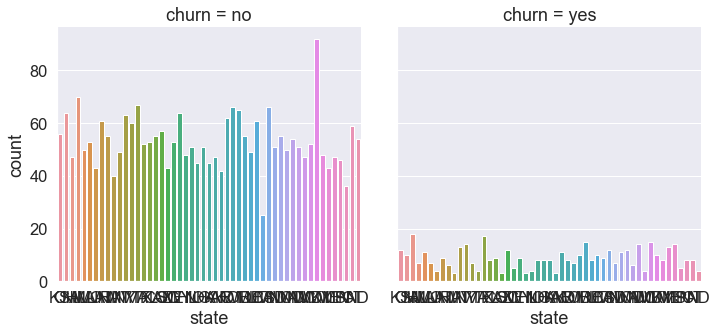

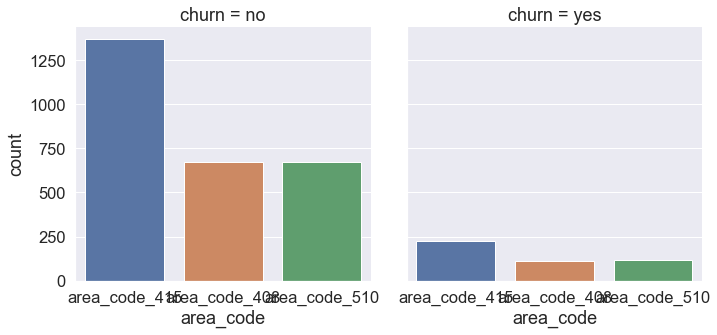

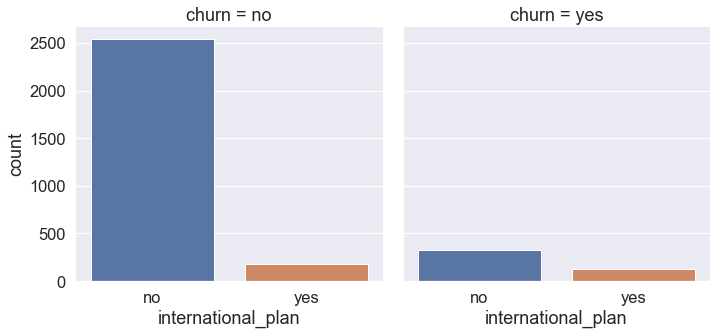

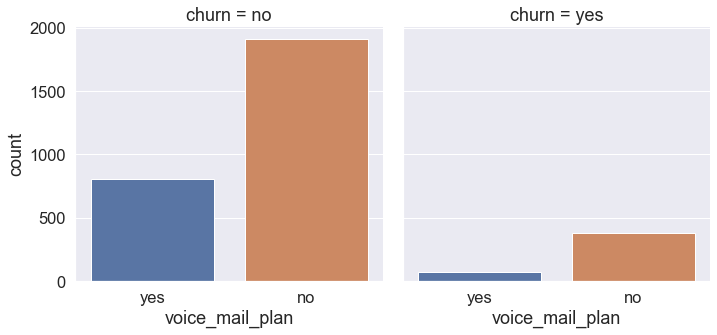

In [186]:
for cat in categoricas:
    sns.catplot(cat, col = 'churn', data =treino, kind = 'count')

In [591]:
#Verificando o estado com o maior número de clientes e seus tipos. 
grup_state_churn = treino.groupby(['state','churn'])[['voice_mail_plan']].count().reset_index(level = ('state','churn'))
pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).\
assign(total = pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).no+\
       pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).yes).\
sort_values(by=['total'],ascending=False)

churn  no  yes  total
state                
WV     90   10    100
NY     66   15     81
MN     65   13     78
OR     66   11     77
AL     69    7     76
VA     71    4     75
WI     66    7     73
OH     64    9     73
WY     63    9     72
UT     60    9     69
VT     61    8     69
ID     60    9     69
TX     51   17     68
CT     57   11     68
MI     54   14     68
IN     60    7     67
KS     53   13     66
NC     55   11     66
WA     52   14     66
MD     49   16     65
CO     56    8     64
MT     50   14     64
RI     57    6     63
NJ     45   18     63
NV     48   13     61
MS     49   12     61
FL     53    8     61
AZ     57    4     61
ME     48   13     61
MO     53    7     60
MA     50   10     60
NM     54    6     60
ND     53    6     59
OK     50    9     59
SC     44   14     58
NE     52    5     57
DE     49    8     57
SD     49    8     57
KY     49    8     57
IL     51    5     56
DC     48    5     53
NH     44    9     53
AR     42   10     52
GA     45    7     52
AK     47    3     50
HI     47    3     50
LA     45    4     49
TN     43    5     48
PA     36    8     44
IA     40    3     43
CA     24    9     33

## Transformação de variáveis

Vamos criar algumas classes que possuem funções de conversões que serão uteis quando necessitarmos converter os dados de validação e teste

In [629]:
#Convertendo as variáveis booleanas
class conversor_bool():
    def __init__(self,colunas = ['international_plan','voice_mail_plan']):
        self.colunas = colunas
    def fit(self,X,y = None):
        return self
    def transform(self,X):
        X_retorno = X.copy()
        X_retorno[self.colunas] = X_retorno[self.colunas].replace({'yes':True,'no':False})
        return X_retorno
    
#Classe que conta a quantidade, para cada variável selecionada em colunas (no caso, as variaveis categoricas) a sua quantidade no dataset
class add_count_columns():
    def __init__(self, colunas):
        self.colunas = colunas
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_retorno = X.copy()
        for cada in self.colunas:
            X_retorno["".join((cada,"_N"))] = X_retorno.groupby(cada)[cada].transform('count')
        for dupla in list(combinations(self.colunas,2)):
            X_retorno["_".join(("_".join((dupla)),"N"))] = X_retorno.groupby(list(dupla))[dupla[0]].transform('count')
        for tripla in list(combinations(self.colunas,3)):
            X_retorno["_".join(("_".join((tripla)),"N"))] = X_retorno.groupby(list(tripla))[tripla[0]].transform('count')
        return X_retorno
    
#Classe que elimina variáveis categoricas que nao serão mais utilizadas    
class drop_all_columns():
    def __init__(self,colunas = ['state','area_code','total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']):
        self.colunas = colunas
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_retorno = X.copy()
        return X_retorno.drop(columns = self.colunas)

In [ ]:
#Vamos alterar as colunas booleanas
colunas_booleanas = ['international_plan','churn','voice_mail_plan']
treino = conversor_bool(colunas_booleanas).transform(treino)
treino

In [594]:
#Adicionar novas variáveis ao dataset, sendo elas as contagens de aparições
treino=add_count_columns(categoricas).transform(treino)
treino

state  account_length      area_code  international_plan  \
0       KS             128  area_code_415               False   
1       OH             107  area_code_415               False   
2       NJ             137  area_code_415               False   
3       OH              84  area_code_408                True   
4       OK              75  area_code_415                True   
...    ...             ...            ...                 ...   
3327    SC              79  area_code_415               False   
3328    AZ             192  area_code_415               False   
3329    WV              68  area_code_415               False   
3330    RI              28  area_code_510               False   
3331    CT             184  area_code_510                True   

      voice_mail_plan  number_vmail_messages  total_day_minutes  \
0                True                     25              265.1   
1                True                     26              161.6   
2               False                      0              243.4   
3               False                      0              299.4   
4               False                      0              166.7   
...               ...                    ...                ...   
3327            False                      0              134.7   
3328             True                     36              156.2   
3329            False                      0              231.1   
3330            False                      0              180.8   
3331            False                      0              213.8   

      total_day_calls  total_day_charge  total_eve_minutes  ...  \
0                 110             45.07              197.4  ...   
1                 123             27.47              195.5  ...   
2                 114             41.38              121.2  ...   
3                  71             50.90               61.9  ...   
4                 113             28.34              148.3  ...   
...               ...               ...                ...  ...   
3327               98             22.90              189.7  ...   
3328               77             26.55              215.5  ...   
3329               57             39.29              153.4  ...   
3330              109             30.74              288.8  ...   
3331              105             36.35              159.6  ...   

      state_area_code_N  state_international_plan_N  state_voice_mail_plan_N  \
0                    34                          58                       18   
1                    38                          64                       25   
2                    32                          57                       43   
3                    20                           9                       48   
4                    26                           5                       42   
...                 ...                         ...                      ...   
3327                 28                          56                       40   
3328                 36                          58                       19   
3329                 47                          93                       71   
3330                 18                          53                       45   
3331                 11                           7                       50   

      area_code_international_plan_N  area_code_voice_mail_plan_N  \
0                               1429                          444   
1                               1429                          444   
2                               1429                         1130   
3                                 69                          588   
4                                145                         1130   
...                              ...                          ...   
3327                            1429                         1130   
3328                            1429                          444   
3329                            

In [596]:
#Por fim, removendo as colunas que nao serão mais utilizadas
colunas_remover = ['state','area_code','total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']
treino = drop_all_columns(colunas_remover).transform(treino)
treino

account_length  international_plan  voice_mail_plan  \
0                128               False             True   
1                107               False             True   
2                137               False            False   
3                 84                True            False   
4                 75                True            False   
...              ...                 ...              ...   
3327              79               False            False   
3328             192               False             True   
3329              68               False            False   
3330              28               False            False   
3331             184                True            False   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3327                      0              134.7               98   
3328                     36              156.2               77   
3329                      0              231.1               57   
3330                      0              180.8              109   
3331                      0              213.8              105   

      total_eve_minutes  total_eve_calls  total_night_minutes  \
0                 197.4               99                244.7   
1                 195.5              103                254.4   
2                 121.2              110                162.6   
3                  61.9               88                196.9   
4                 148.3              122                186.9   
...                 ...              ...                  ...   
3327              189.7               68                221.4   
3328              215.5              126                279.1   
3329              153.4               55                191.3   
3330              288.8               58                191.9   
3331              159.6               84                139.2   

      total_night_calls  ...  state_area_code_N  state_international_plan_N  \
0                    91  ...                 34                          58   
1                   103  ...                 38                          64   
2                   104  ...                 32                          57   
3                    89  ...                 20                           9   
4                   121  ...                 26                           5   
...                 ...  ...                ...                         ...   
3327                128  ...                 28                          56   
3328                 83  ...                 36                          58   
3329                123  ...                 47                          93   
3330                 91  ...                 18                          53   
3331                137  ...                 11                           7   

      state_voice_mail_plan_N  area_code_international_plan_N  \
0                          18                            1429   
1                          25                            1429   
2                          43                            1429   
3                          48                              69   
4                          42                             145   
...                       ...                             ...   
3327                       40                            1429   
3328                       19                            1429   
3329                       71                            1429   
3330                       45                             703   
3331                   

## Análise exploratória dos novos dados

In [107]:
#Verificando quem sao as novas variaveis, juntamente com a variavel target
novas_variaveis = list(treino.columns[["_N" in x for x in treino.columns]])
novas_variaveis_churn = novas_variaveis.copy()
novas_variaveis_churn.append('churn')

mapeamento2 = {}
for i in range(0,len(novas_variaveis_churn)-1):
    mapeamento2[novas_variaveis_churn[i]] = i
mapeamento2

{'state_N': 0,
 'area_code_N': 1,
 'international_plan_N': 2,
 'voice_mail_plan_N': 3,
 'state_area_code_N': 4,
 'state_international_plan_N': 5,
 'state_voice_mail_plan_N': 6,
 'area_code_international_plan_N': 7,
 'area_code_voice_mail_plan_N': 8,
 'international_plan_voice_mail_plan_N': 9,
 'state_area_code_international_plan_N': 10,
 'state_area_code_voice_mail_plan_N': 11,
 'state_international_plan_voice_mail_plan_N': 12,
 'area_code_international_plan_voice_mail_plan_N': 13}

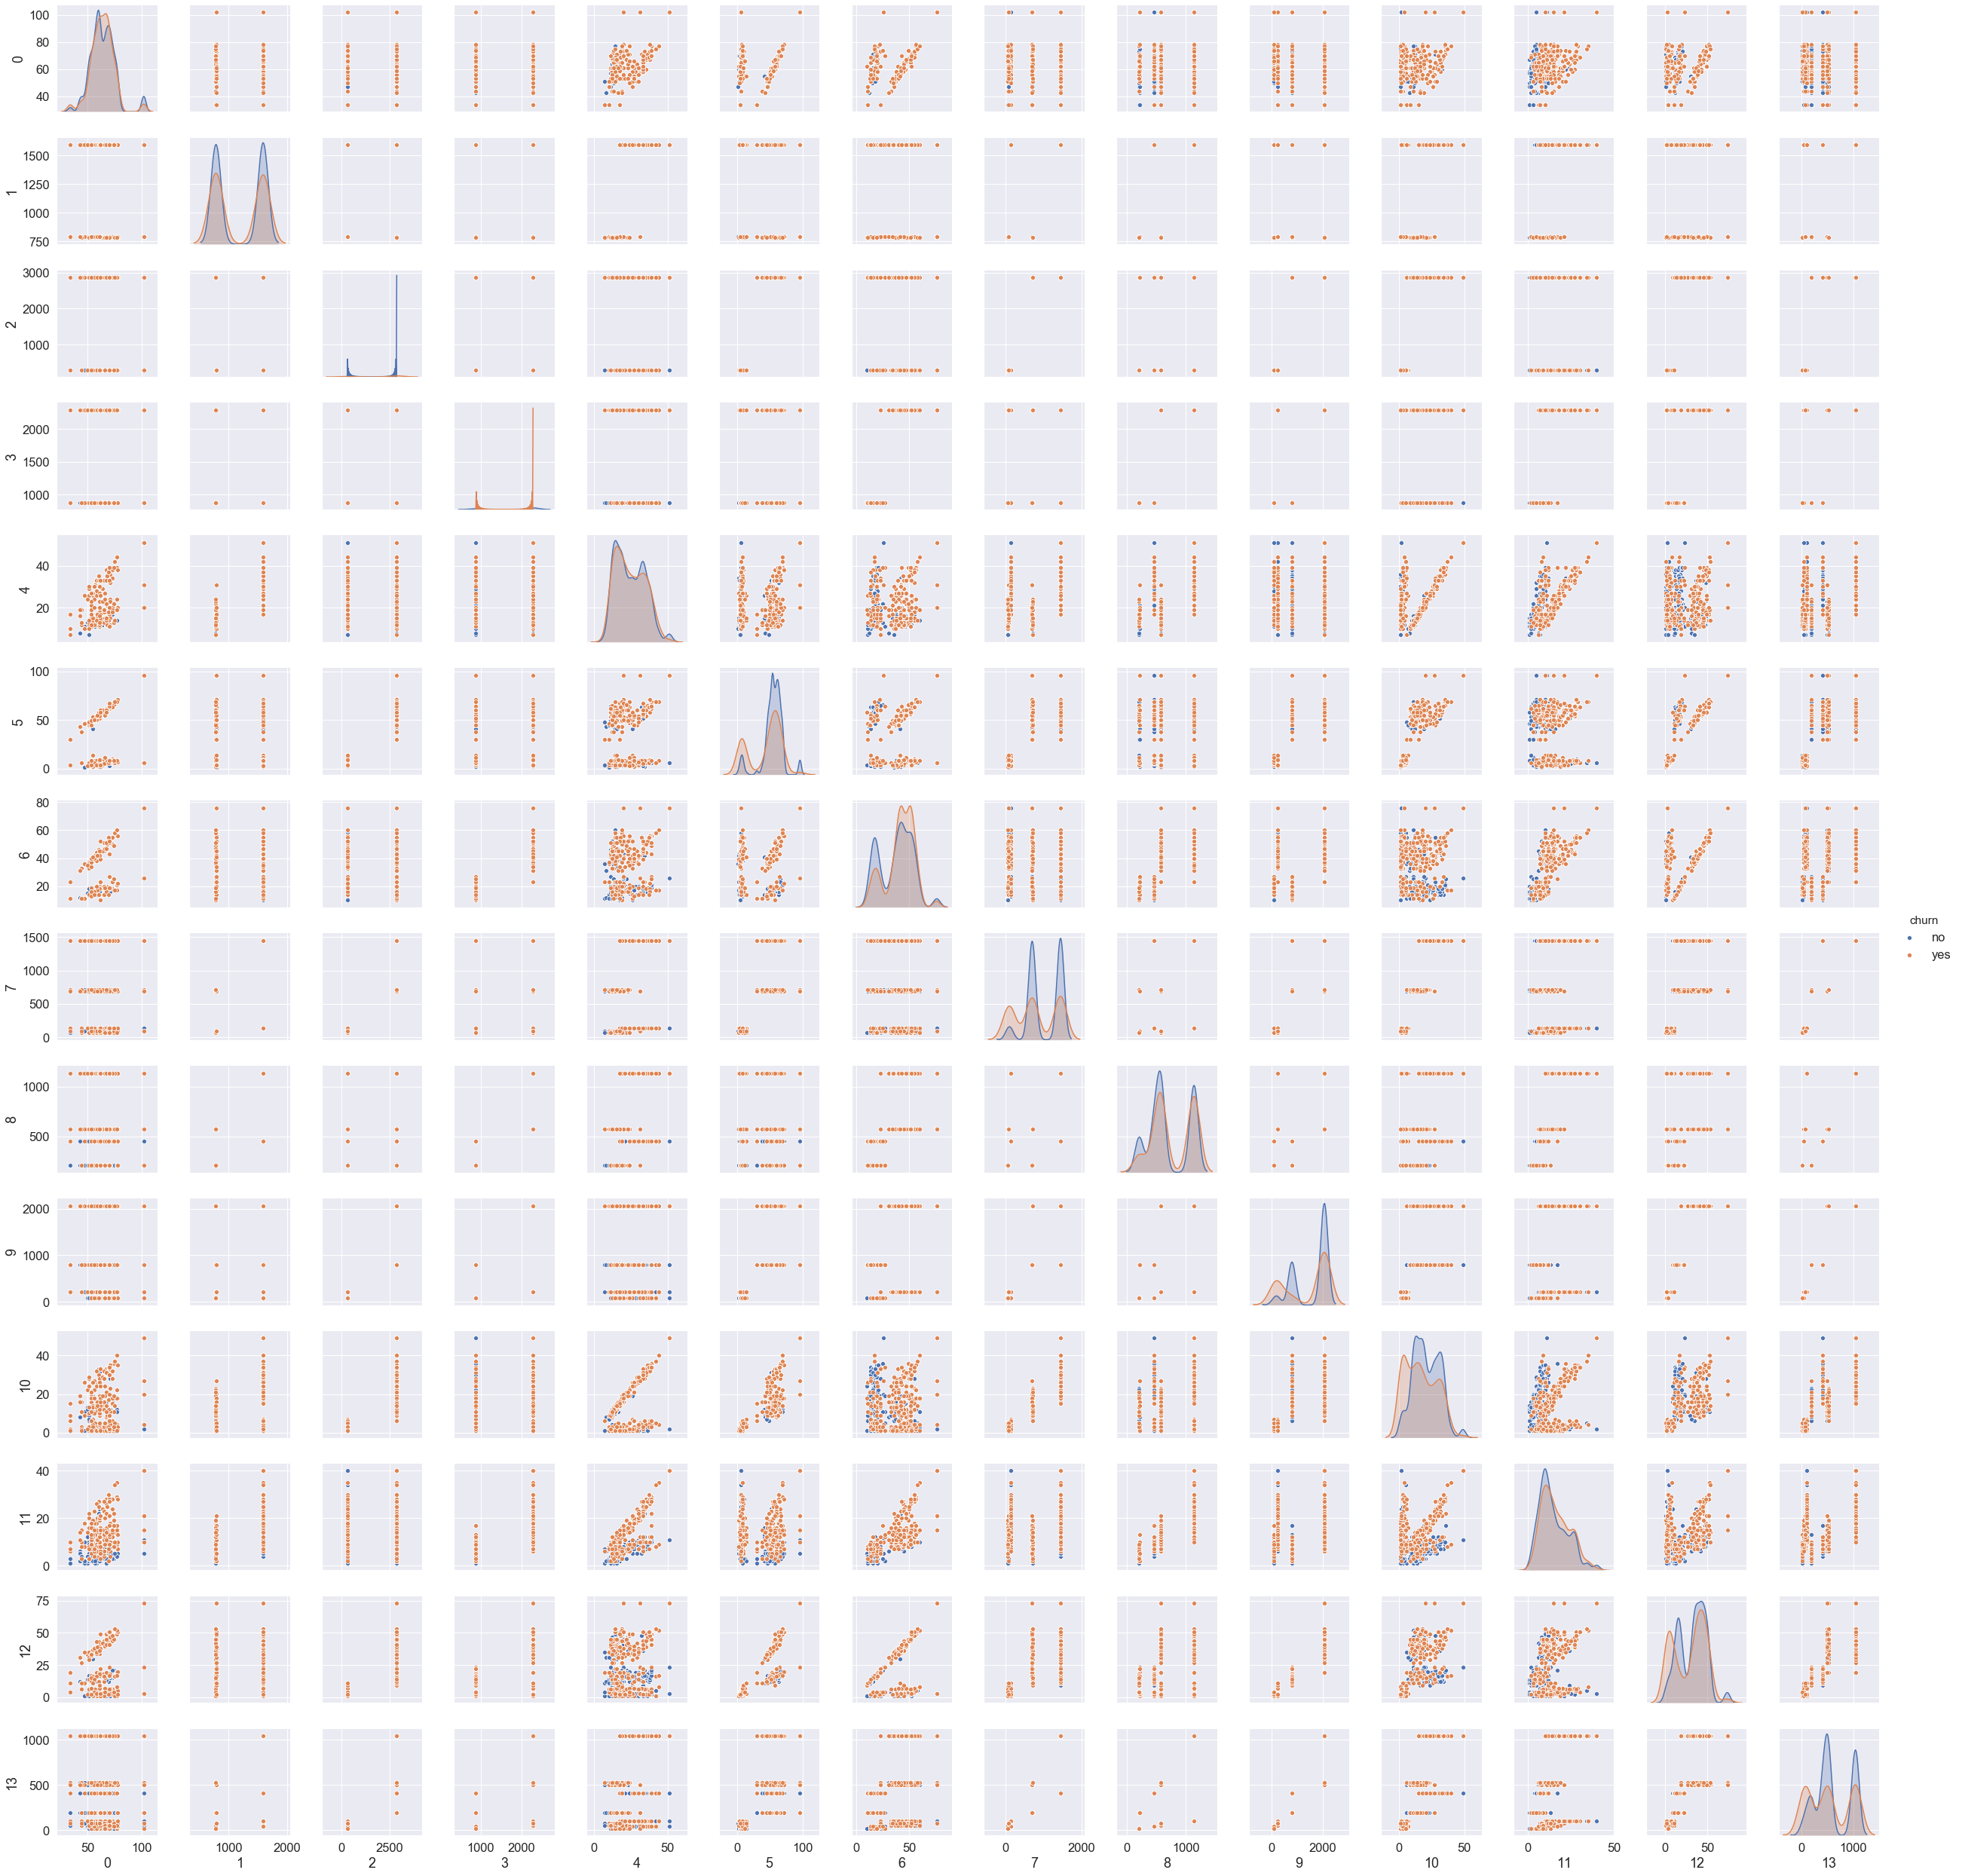

In [191]:
sns.pairplot(treino[novas_variaveis_churn].rename(columns = mapeamento2),hue = 'churn')

In [108]:
#Vamos explorar os novos dados
explore_describe(treino)

variable     type  na  na_pct  \
0                                   account_length    int64   0     0.0   
1                               international_plan     bool   0     0.0   
2                                  voice_mail_plan     bool   0     0.0   
3                            number_vmail_messages    int64   0     0.0   
4                                total_day_minutes  float64   0     0.0   
5                                  total_day_calls    int64   0     0.0   
6                                total_eve_minutes  float64   0     0.0   
7                                  total_eve_calls    int64   0     0.0   
8                              total_night_minutes  float64   0     0.0   
9                                total_night_calls    int64   0     0.0   
10                              total_intl_minutes  float64   0     0.0   
11                                total_intl_calls    int64   0     0.0   
12                   number_customer_service_calls    int64   0     0.0   
13                                           churn     bool   0     0.0   
14                                         state_N    int64   0     0.0   
15                                     area_code_N    int64   0     0.0   
16                            international_plan_N    int64   0     0.0   
17                               voice_mail_plan_N    int64   0     0.0   
18                               state_area_code_N    int64   0     0.0   
19                      state_international_plan_N    int64   0     0.0   
20                         state_voice_mail_plan_N    int64   0     0.0   
21                  area_code_international_plan_N    int64   0     0.0   
22                     area_code_voice_mail_plan_N    int64   0     0.0   
23            international_plan_voice_mail_plan_N    int64   0     0.0   
24            state_area_code_international_plan_N    int64   0     0.0   
25               state_area_code_voice_mail_plan_N    int64   0     0.0   
26      state_international_plan_voice_mail_plan_N    int64   0     0.0   
27  area_code_international_plan_voice_mail_plan_N    int64   0     0.0   

    unique   min quat25 median     mean  quat75    max     std    skewness  \
0      212     1     74    101   101.21     127    243   39.71   0.0950445   
1        2     -      -      -        -       -      -       -           -   
2        2     -      -      -        -       -      -       -           -   
3       46     0      0      0     8.06      19     51   13.68     1.27626   
4     1630     0  143.9  179.4   179.78  216.05  350.8   54.25  -0.0283876   
5      119     0     87    101   100.54     114    165   20.01   -0.119879   
6     1567  31.2    167  201.4   201.13   235.5  363.7   50.39  -0.0220579   
7      122    12     87    100   100.14     114    170   19.83  -0.0242203   
8     1560  23.2  166.7  201.4   200.73  235.55    395   50.87  0.00359575   
9      118    33     87    100   100.07     113    166   19.52   0.0292299   
10     162     0    8.5   10.3    10.24    12.1     20    2.79   -0.252654   
11      21     0      3      4      4.5       6     20    2.48     1.32588   
12      10     0      1      1     1.56       2      9    1.31     1.10029   
13       2     -      -      -        -       -      -       -           -   
14      28    34     57     63    64.24      69    105   11.88     1.01171   
15       3   801    801    805  1179.08    1565   1565  381.03   0.0258319   
16       2   306   2865   2865  2618.06    2865   2865  755.73    -2.73434   
17       2   872    872   2299  1906.59    2299   2299  637.27    -1.00833   
18      35     7     16     23    24.52      32     52     9.7    0.480512   
19      40     1     50     56    53.22      63     98   18.45   -0.989563   
20      46     9     23     42    38.95      50     76   15.37   -0.125281   
21       6    69    706    732   978.93    1427   1427  440.49   -0.363808   
22       6   210    444    591   706.17    1121   1121  329.06     0.169

## Seleção de variáveis

Como agora todas as variáveis são do tipo numéricas, podemos aplicar um PCA, para veficar a relevancia das variáveis a um modelo de Regressão Logística.

Contudo, para aplicarmos PCA, será necessária a padronização das variáveis

#### Tratamento de *outliers*

Vamos realizar um tratamento dos *outliers* antes de padronizar os dados

In [231]:
#Vamos jogar os dados outliers para a media (sem considerar os outliers)
def trata_outliers(dataset,colunas_variaveis):
    for cada_colunas in colunas_variaveis:
        desvio = dataset[cada_coluna].std()
        media = dataset[cada_coluna].mean()
        dataset[(dataset[cada_coluna] >= media + 3*desvio) | (dataset[cada_coluna] <= media -3*desvio)] = media
        return dataset
    
numericas = explore_describe(treino)['variable'][explore_describe(treino)['type'].\
                                         map(lambda x: True if (('int' in str(x)) or ('float' in str(x))) else False)].to_list()        

treino = trata_outliers(treino,numericas)

### Padronização dos dados

In [232]:
#Dividindo as variáveis que compõem o dataset da variável target
X = treino.drop(columns="churn")
y = treino.churn

In [233]:
padronizador = StandardScaler()
parametros_dados_padronizados = padronizador.fit(X)
X_norm = parametros_dados_padronizados.transform(X)
X_norm

array([[ 0.69124528, -0.06385518,  0.14061397, ..., -0.59359718,
        -1.00891778, -0.55247522],
       [ 0.15673653, -0.06385518,  0.14061397, ...,  0.2125154 ,
        -0.69982792, -0.55247522],
       [ 0.92032046, -0.06385518, -0.10795807, ...,  0.7883101 ,
         0.72198544,  1.30722961],
       ...,
       [-1.85403451, -0.06385518, -0.10795807, ..., -0.24812036,
         0.22744166, -0.24104139],
       [ 2.11660196,  0.18514032, -0.10795807, ..., -0.70875612,
        -1.56527952, -1.51347101],
       [-0.6832058 , -0.06385518,  0.14061397, ..., -0.70875612,
        -1.13255372, -0.55247522]])

In [598]:
#Salvando os parâmetros padronizados
pickle.dump(parametros_dados_padronizados,open('parametros/parametros.sav','wb'))

### Aplicando PCA

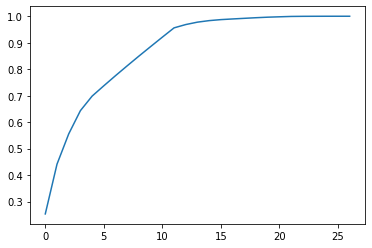

In [234]:
#Vamos testar como se comporta o PCA, variando a quantidade de componentes
variance_ratio = [sum(PCA(n_components=i).fit(X_norm,y).explained_variance_ratio_) for i in range(1,28)]
plt.plot(variance_ratio)

Nota-se que, realmente, não há a necessidade de tantas variáveis para representar 100% dos dados. Com 10 componentes, já é possível obter 90% das informações do dataset

In [235]:
pd.DataFrame({"Qtde_Componetes": range(1,28),"Representatividade":variance_ratio})

Qtde_Componetes  Representatividade
0                 1            0.253541
1                 2            0.441366
2                 3            0.555605
3                 4            0.643544
4                 5            0.698397
5                 6            0.737418
6                 7            0.775641
7                 8            0.812929
8                 9            0.849598
9                10            0.885488
10               11            0.921071
11               12            0.956142
12               13            0.968644
13               14            0.977717
14               15            0.983483
15               16            0.987260
16               17            0.989761
17               18            0.992135
18               19            0.994450
19               20            0.996446
20               21            0.997891
21               22            0.999258
22               23            0.999696
23               24            0.999880
24               25            0.999972
25               26            1.000000
26               27            1.000000

In [236]:
#Portanto, vamos adotar 5 componentes
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(X_norm,y)
X_PCA

array([[-1.32445947,  0.73329452, -3.23638608, ...,  0.50742456,
        -0.7954391 ,  0.41358346],
       [-0.29354714,  1.43978483, -3.33265199, ...,  0.7947464 ,
        -0.3139011 , -0.55877172],
       [ 2.954788  , -0.37553124, -0.50474787, ..., -0.18410289,
         0.47259712,  1.65131238],
       ...,
       [-0.29281015, -0.27575097,  1.65739214, ...,  0.4874897 ,
        -2.07241017,  0.16773142],
       [-3.76534674,  0.36736852,  3.45620429, ..., -0.99803176,
        -0.37758343,  1.6172174 ],
       [-1.88513518,  0.71797319, -3.02264099, ...,  0.70647555,
        -1.73682564, -0.12497032]])

## SMOTE

Devido ao desbalanceamento dos dados de treino para a variável *churn*, temos que aplicar uma técnica de balanceamento para contornar este problema

In [262]:
balanceador = SVMSMOTE()
X_PCA_balanceado,y_balanceado = balanceador.fit_resample(X_PCA,y.astype('bool'))
X_PCA_balanceado

array([[-1.32445947,  0.73329452, -3.23638608, ...,  0.50742456,
        -0.7954391 ,  0.41358346],
       [-0.29354714,  1.43978483, -3.33265199, ...,  0.7947464 ,
        -0.3139011 , -0.55877172],
       [ 2.954788  , -0.37553124, -0.50474787, ..., -0.18410289,
         0.47259712,  1.65131238],
       ...,
       [11.82744604, 52.72802441,  8.48398756, ...,  0.56927295,
        -0.67311455, -0.2489124 ],
       [-5.71686554,  1.98964025,  1.0402289 , ...,  1.08892425,
        -1.14083533,  0.42119372],
       [-1.54917281,  0.69455129,  2.57200078, ..., -0.57648981,
         0.76904965,  0.44808428]])

## Aplicando modelo de classificação

Vamos realizar alguns testes com alguns modelos

In [309]:
modelos = {"LR":LogisticRegression(),
          "LA":LinearDiscriminantAnalysis(),
          "KNN":KNeighborsClassifier(),
          "NB":GaussianNB(),
          "TREE": DecisionTreeClassifier(),
          "SVM":SVC(),
          "XGB":XGBClassifier(),
          "GBC":GradientBoostingClassifier(),
          "ABC":AdaBoostClassifier(),
          "RF":RandomForestClassifier()}

CrossValidation = KFold(n_splits=8)
resultados = []
for nome_modelo,modelo in modelos.items():
    resultados.append(cross_val_score(estimator=modelo,X = X_PCA_balanceado, y= y_balanceado, cv= CrossValidation,scoring = "accuracy"))
    print("%s com média de acurárica de %.2f" % (nome_modelo,100*np.mean(resultados[len(resultados)-1])))

LR com média de acurárica de 79.07
LA com média de acurárica de 79.55
KNN com média de acurárica de 85.40
NB com média de acurárica de 70.78
TREE com média de acurárica de 83.03
SVM com média de acurárica de 82.25
XGB com média de acurárica de 87.61
GBC com média de acurárica de 82.23
ABC com média de acurárica de 78.18
RF com média de acurárica de 88.72


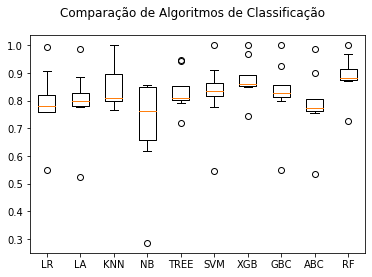

In [310]:
# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(modelos.keys())
plt.show()

Os resultados foram melhores utilizando-se *Random Forest*, mas vamos avaliar o modelo, fazendo algumas alterações nos parâmetros, também, para a Regressão Logística

## Otimizando a Regressão Logística

In [322]:
#Quantidade de iterações
iterations = 1000

#Criando os valores de Grid para a busca e otimização
valores_grid = {"penalty":["l1", "l2", "elasticnet"],
               "C": [0,0.01,0.05,0.1,0.5,0.8,1,2,5],
               "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
               "max_iter":[10,30,50,100,500,1000]}


# Criando o grid e utilizando como score (padrão) a acurácia
LRsearch = RandomizedSearchCV(estimator = modelos['LR'], 
                             param_distributions = valores_grid, 
                             n_iter = iterations,
                             scoring = 'accuracy',
                             cv = CrossValidation)
LRsearch.fit(X_PCA_balanceado, y_balanceado)
print(LRsearch.best_params_)
print('Melhor score encontrado foi %.2f' % (100*LRsearch.best_score_))

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 10, 'C': 5}
Melhor score encontrado foi 79.66


In [323]:
#Salvando o melhor modelo encontrado
pickle.dump(LRsearch.best_estimator_, open('modelos/modelo_LR.sav', 'wb'))

Façamos o mesmo para o modelo de Random Forest

In [324]:
#Criando os valores de Grid para a busca e otimização
valores_grid = {'n_estimators': [1,10,100,500,1000], 'criterion': ['gini', 'entropy'], 'min_impurity_decrease':[0,0.1,0.5,1,5,10]}

# Criando o grid e utilizando como score (padrão) a acurácia
RFsearch = RandomizedSearchCV(estimator = modelos['RF'], 
                             param_distributions = valores_grid, 
                             n_iter = iterations,
                             scoring = 'accuracy',
                             cv = CrossValidation)
RFsearch.fit(X_PCA_balanceado, y_balanceado)
print(RFsearch.best_params_)
print('Melhor score encontrado foi %.2f' % (100*RFsearch.best_score_))

{'n_estimators': 500, 'min_impurity_decrease': 0, 'criterion': 'entropy'}
Melhor score encontrado foi 89.34


In [325]:
#Salvando o melhor modelo encontrado
pickle.dump(RFsearch.best_estimator_, open('modelos/modelo_RF.sav', 'wb'))

## Carregando os modelos salvos e parâmetros salvos

In [599]:
parametros_dados_padronizados = pickle.load(open('parametros/parametros.sav','rb'))
RFmodelo = pickle.load(open('modelos/modelo_RF.sav','rb'))
LRmodelo = pickle.load(open('modelos/modelo_LR.sav','rb'))

## Comparando os resultados do modelo com os dados de validação

In [641]:
#Vamos montar um pipeline para tratar os dados de validação, separados ao começo do estudo
steps = [('conversor_booleano',conversor_bool()),
         ('adiciona_contagem',add_count_columns(categoricas)),
        ('drop_col',drop_all_columns()),
        ('padroniza',parametros_dados_padronizados),
        ('PCA',pca)]

In [642]:
pipe = Pipeline(steps)

In [643]:
X_validacao = validacao.drop(columns='churn')
y_validacao = validacao.churn.replace({'yes':True,'no':False})
validacao_fit_transform = pipe.fit_transform(X_validacao,y_validacao)
validacao_fit_transform

In [644]:
validacao_fit_transform

array([[-2.56490847,  0.30392734, -1.03507632, ..., -0.51322896,
        -1.44856248,  1.69906038],
       [-1.43001837, -1.72863284, -1.51304246, ..., -0.4946402 ,
         0.74069302,  1.88881416],
       [ 1.6219882 , -2.63498141, -0.74617244, ...,  0.56044247,
         0.19241338, -0.68205364],
       ...,
       [-1.10348358, -1.18798525, -1.74438028, ..., -0.83047594,
         0.21031295, -1.02452667],
       [-1.36285868, -1.50994973, -1.21776282, ..., -1.25981451,
        -0.82586897, -0.95153999],
       [ 0.50569951, -1.2290681 ,  0.15655338, ...,  1.38610332,
         0.59786458,  1.65737254]])

In [651]:
confusion_matrix(y_pred=LRmodelo.predict(validacao_fit_transform),y_true=y_validacao)

array([[141,   4],
       [  7,  15]], dtype=int64)